# PCB 瑕疵檢測
- 資料集: [PCB Defect dataset](https://www.kaggle.com/datasets/norbertelter/pcb-defect-dataset)
- 模型　: [Yolo V11 s](https://docs.ultralytics.com/models/yolo11/)

## 匯入套件

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display
from ultralytics import YOLO
from ultralytics.utils.ops import xywhn2xyxy
from ultralytics.utils.plotting import Annotator, colors
import yaml
import wandb
%matplotlib inline

## 設定 Project 及 Logger

In [2]:
PROJECT = "pcb_defect"
NAME = "v3"
experiment_path = Path(f"{PROJECT}/{NAME}")
experiment_test_path = Path(f"{PROJECT}/{NAME}_test")

In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: devilhyt. Use `wandb login --relogin` to force relogin


True

## 觀察資料集

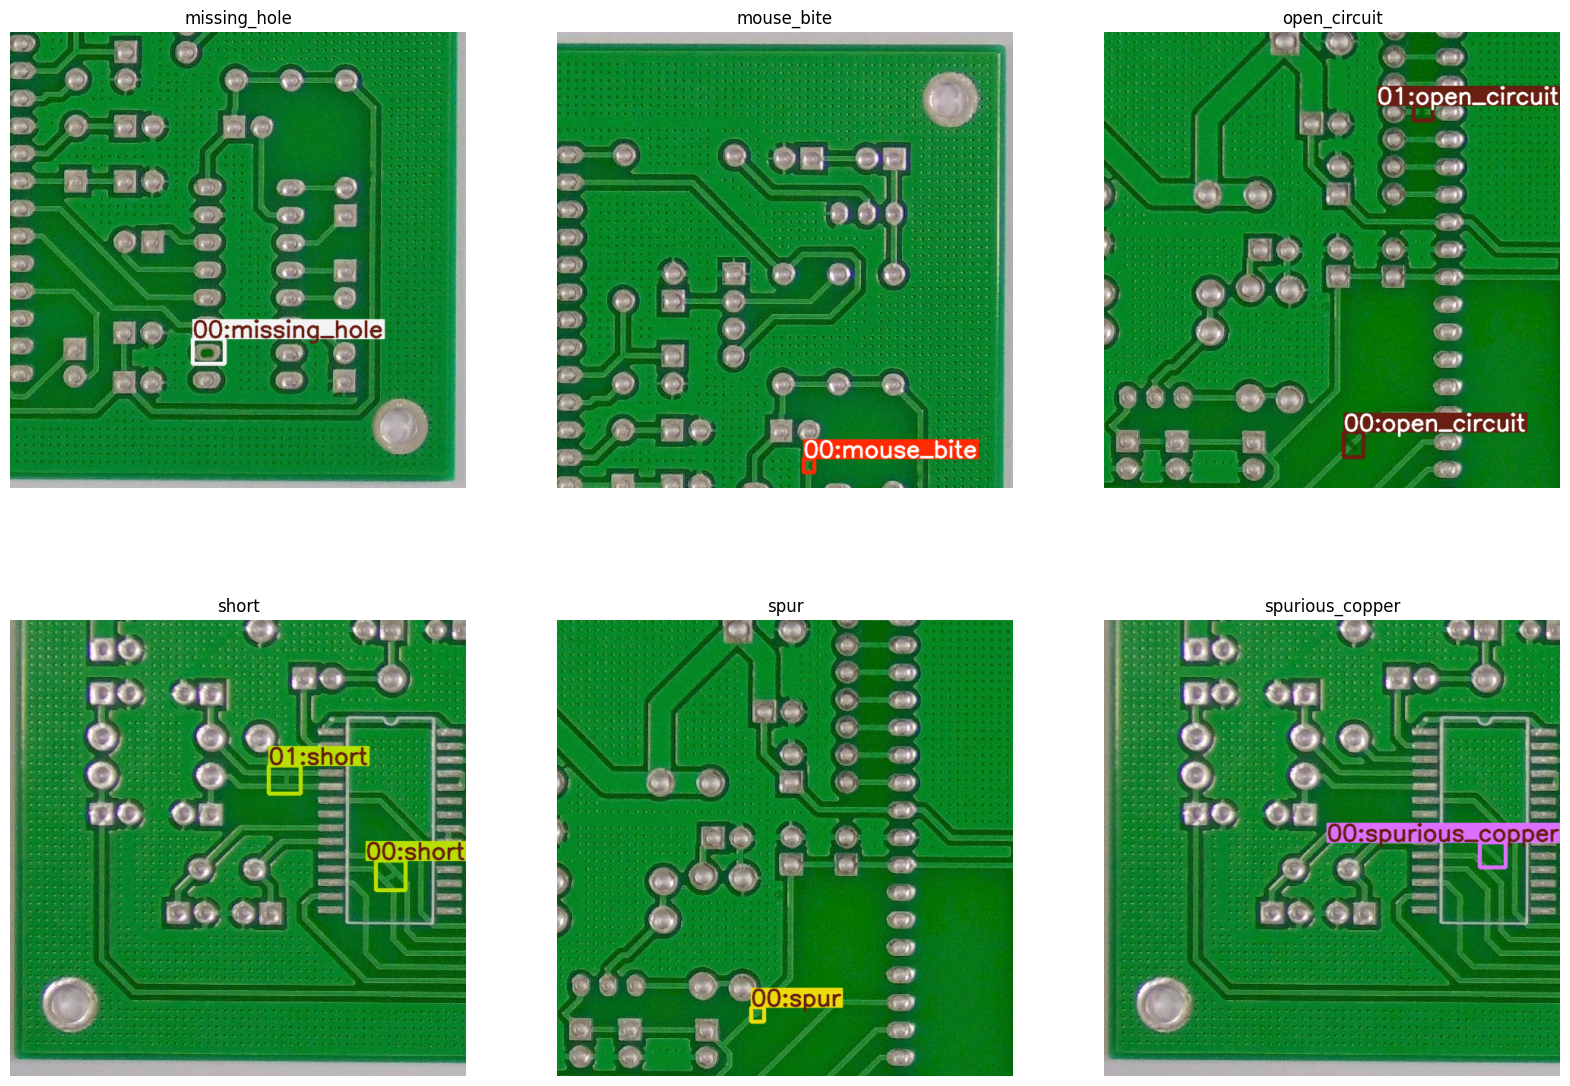

In [4]:
# Load class map
with open("dataset/pcb-defect-dataset/data.yaml") as f:
    class_map = yaml.safe_load(f)["names"]

# define example images
examples = [
    ("missing_hole", "l_light_01_missing_hole_01_1_600"),
    ("mouse_bite", "l_light_01_mouse_bite_01_1_600"),
    ("open_circuit", "l_light_01_open_circuit_01_1_600"),
    ("short", "l_light_01_short_01_2_600"),
    ("spur", "l_light_01_spur_01_2_600"),
    ("spurious_copper", "l_light_01_spurious_copper_01_1_600"),
]

# plot example images
fig, axs = plt.subplots(2, 3, figsize=(20,14))
for i, (class_name, file_name) in enumerate(examples):
    image = plt.imread(f"dataset/pcb-defect-dataset/train/images/{file_name}.jpg")
    labels = np.loadtxt(
        f"dataset/pcb-defect-dataset/train/labels/{file_name}.txt", ndmin=2
    )
    annotator = Annotator(image, line_width=3)
    for nb, box in enumerate(labels):
        c_idx, *box = box
        box = xywhn2xyxy(np.array(box), 600, 600)
        label = f"{str(nb).zfill(2)}:{class_map.get(int(c_idx))}"
        annotator.box_label(box, label, color=colors(c_idx, bgr=True))
    image_with_bboxes = annotator.result()
    x, y = i // 3, i % 3
    axs[x, y].imshow(image_with_bboxes)
    axs[x, y].title.set_text(class_name)
    axs[x, y].axis("off")
plt.show()

## 設定訓練參數

In [4]:
training_setting = {
    "data": Path("dataset/pcb-defect-dataset/data.yaml").resolve(),
    "epochs": 300,
    "patience": 10,
    "batch": 64,
    "imgsz": 600,
    "project": PROJECT,
    "name": NAME,
    "plots": True,
    "optimizer": "AdamW",
    "lr0": 0.0001,
    "lrf": 0.1,
    "momentum": 0.9,
}

## 設定資料增強

In [5]:
augmentation = {
    "hsv_h": 0.015,
    "hsv_s": 0.7,
    "hsv_v": 0.4,
    "degrees": 45.0,
    "translate": 0.1,
    "scale": 0.5,
    "shear": 5.0,
    "perspective": 0.0,
    "flipud": 0.5,
    "fliplr": 0.5,
    "mosaic": 1.0,
    "erasing": 0.2,
    "crop_fraction": 1.0,
}

## 訓練模型，並評估驗證集

In [6]:
model = YOLO("yolo11s.pt")
results = model.train(**training_setting, **augmentation)

New https://pypi.org/project/ultralytics/8.3.47 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.10 torch-2.5.1+cu124 CUDA:0 (NVIDIA TITAN RTX, 24205MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/home/g113056077/Projects/nchu-stuff/2024-fall/cv/pcb_defect_detection/dataset/pcb-defect-dataset/data.yaml, epochs=300, time=None, patience=10, batch=64, imgsz=600, save=True, save_period=-1, cache=False, device=None, workers=8, project=pcb_defect, name=v3, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=Fals

Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
WARNING ⚠️ imgsz=[600] must be multiple of max stride 32, updating to [608]


train: Scanning /home/g113056077/Projects/nchu-stuff/2024-fall/cv/pcb_defect_detection/dataset/pcb-defect-dataset/train/labels.cache... 6370 images, 2164 backgrounds, 0 corrupt: 100%|██████████| 8534/8534 [00:00<?, ?it/s]
val: Scanning /home/g113056077/Projects/nchu-stuff/2024-fall/cv/pcb_defect_detection/dataset/pcb-defect-dataset/val/labels.cache... 802 images, 264 backgrounds, 0 corrupt: 100%|██████████| 1066/1066 [00:00<?, ?it/s]


Plotting labels to pcb_defect/v3/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 608 train, 608 val
Using 8 dataloader workers
Logging results to pcb_defect/v3
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300        15G      2.281       4.18      1.558         46        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]

                   all       1066       1595      0.126      0.323      0.194     0.0871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      15.1G      1.778      1.769      1.252         41        608: 100%|██████████| 134/134 [00:54<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.47it/s]

                   all       1066       1595       0.62      0.682      0.619      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      15.1G      1.653       1.42       1.19         44        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]

                   all       1066       1595      0.819      0.812      0.855      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      15.1G      1.577       1.21      1.151         51        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]

                   all       1066       1595      0.894      0.874      0.928      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      15.1G      1.539      1.082       1.14         35        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.54it/s]

                   all       1066       1595      0.892      0.869      0.915      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      15.1G      1.513      1.015      1.123         38        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.53it/s]

                   all       1066       1595      0.892      0.851      0.913      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      15.1G      1.499     0.9631      1.118         41        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.54it/s]

                   all       1066       1595      0.924      0.887      0.948      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      15.1G      1.493     0.9278      1.119         52        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]

                   all       1066       1595      0.922      0.903      0.942       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      15.1G      1.475     0.8946      1.103         45        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595      0.947      0.916      0.951      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      15.1G      1.464     0.8624      1.104         48        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.53it/s]

                   all       1066       1595      0.905      0.898      0.942      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      15.1G      1.447     0.8344      1.099         40        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.955      0.939      0.964      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      15.1G      1.429     0.8043      1.088         46        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]

                   all       1066       1595       0.95      0.906      0.959      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      15.1G      1.421     0.7866       1.09         26        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.50it/s]

                   all       1066       1595      0.955      0.933      0.961      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      15.1G      1.418     0.7742      1.086         40        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595      0.959      0.941       0.96      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      15.1G      1.409     0.7554      1.084         57        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.53it/s]

                   all       1066       1595      0.946      0.962      0.972      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      15.1G      1.404     0.7486      1.077         42        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.54it/s]

                   all       1066       1595      0.964      0.941      0.969      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      15.1G       1.39     0.7287      1.078         28        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.964      0.942      0.973      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      15.1G      1.402     0.7244      1.078         46        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.922      0.936      0.957      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      15.1G      1.388     0.7083      1.078         45        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.971      0.952      0.976      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      15.1G       1.38     0.6964      1.071         60        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.52it/s]

                   all       1066       1595      0.967      0.949      0.976      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      15.1G      1.371     0.6972      1.069         34        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.53it/s]

                   all       1066       1595      0.962      0.963      0.976      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      15.1G      1.368     0.6964      1.068         48        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.50it/s]

                   all       1066       1595      0.964      0.964      0.976      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      15.1G      1.356     0.6749      1.064         41        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.51it/s]

                   all       1066       1595      0.962      0.955      0.977      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      15.1G      1.352     0.6756      1.066         39        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.51it/s]

                   all       1066       1595      0.974      0.958      0.976      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      15.1G      1.357     0.6712      1.064         40        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]

                   all       1066       1595      0.968      0.954      0.975      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      15.1G      1.344     0.6616      1.059         44        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595      0.976      0.964      0.979      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      15.1G      1.339     0.6628      1.051         47        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.54it/s]

                   all       1066       1595      0.977      0.965      0.984      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      15.1G      1.347     0.6591      1.064         43        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595      0.966       0.96      0.979       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      15.1G      1.333     0.6407      1.056         34        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.52it/s]

                   all       1066       1595      0.963      0.956      0.979      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      15.1G      1.321     0.6357      1.053         50        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]

                   all       1066       1595      0.972      0.962       0.98      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      15.1G      1.327     0.6364       1.05         52        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.977      0.971      0.983      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      15.1G       1.32     0.6346      1.046         30        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.54it/s]

                   all       1066       1595      0.974      0.969      0.983      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      15.1G      1.318     0.6318       1.05         53        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595       0.98      0.963      0.983       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      15.1G      1.309     0.6319      1.044         38        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.52it/s]

                   all       1066       1595      0.979      0.975      0.986      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      15.1G      1.303     0.6249       1.04         50        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.974      0.969      0.986       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      15.1G      1.311     0.6194      1.044         44        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.974      0.961      0.977      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      15.1G      1.297     0.6139       1.04         58        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.975      0.963      0.982      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      15.1G      1.282     0.6042      1.033         49        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]

                   all       1066       1595      0.974       0.97      0.986      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      15.1G      1.281     0.6034      1.032         52        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.975      0.982      0.989      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      15.1G      1.278     0.6018      1.033         58        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.973      0.968      0.984      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      15.1G      1.271     0.5978       1.03         41        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.963      0.974      0.986      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      15.1G      1.266     0.5951      1.028         45        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595      0.977      0.965      0.986      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      15.1G      1.253      0.588      1.026         38        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.54it/s]

                   all       1066       1595      0.977      0.974      0.988      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      15.1G      1.263     0.5956      1.029         34        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.981      0.977       0.99      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      15.1G      1.254     0.5866       1.02         47        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.978      0.968      0.987      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      15.1G      1.271     0.5949      1.032         49        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.977      0.981      0.988      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      15.1G      1.249     0.5776       1.02         36        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.972      0.983      0.987      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      15.1G      1.242     0.5791      1.018         34        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]

                   all       1066       1595      0.979      0.969      0.987      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      15.1G      1.248     0.5807      1.017         46        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.974      0.979      0.987      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      15.1G      1.237     0.5729      1.014         37        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]

                   all       1066       1595      0.974      0.981      0.989      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      15.1G      1.234     0.5657      1.014         38        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.51it/s]

                   all       1066       1595      0.981      0.975      0.989      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      15.1G      1.223     0.5616      1.012         44        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.978       0.98      0.989      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      15.1G      1.229     0.5701      1.011         34        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.982      0.977      0.989      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      15.1G       1.22     0.5634      1.008         42        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.982      0.978      0.991       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      15.1G      1.209     0.5598      1.006         46        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.53it/s]

                   all       1066       1595      0.976      0.983      0.991      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      15.1G      1.208     0.5568      1.006         42        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.978      0.981       0.99       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      15.1G      1.207      0.556      1.001         42        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.979      0.982       0.99      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      15.1G      1.201     0.5538     0.9958         40        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.975      0.986      0.991      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      15.1G      1.188     0.5398     0.9945         46        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.973      0.982      0.991      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      15.1G      1.192      0.549     0.9968         41        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.982      0.984      0.992      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      15.1G       1.19      0.552     0.9961         34        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.985      0.981       0.99      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      15.1G       1.18     0.5407     0.9912         53        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.982      0.985      0.992        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      15.1G       1.18     0.5511     0.9873         43        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.981      0.978      0.992      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      15.1G      1.179     0.5462     0.9882         69        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.988      0.974      0.991      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      15.1G      1.164     0.5383     0.9855         45        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595      0.981      0.985      0.991      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      15.1G      1.176     0.5348     0.9891         42        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.982      0.984      0.991      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      15.1G      1.165     0.5353     0.9883         38        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595      0.982      0.986      0.991      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      15.1G      1.156     0.5293     0.9851         32        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.984      0.978      0.992      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      15.1G      1.158     0.5291      0.988         46        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.983      0.984      0.992      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      15.1G      1.147     0.5236     0.9803         36        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.985      0.986      0.992      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      15.1G      1.151     0.5233     0.9789         59        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.986      0.985      0.992      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      15.1G      1.136     0.5172      0.977         43        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.981       0.99      0.993      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      15.1G       1.14     0.5208     0.9797         34        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595      0.988      0.983      0.993      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      15.1G      1.132     0.5229      0.974         54        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.979       0.99      0.992      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      15.1G      1.126     0.5189     0.9752         34        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.986      0.984      0.993      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      15.1G      1.123     0.5198     0.9747         39        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595      0.984      0.986      0.992      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      15.1G      1.117     0.5113     0.9695         36        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.982      0.987      0.992      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      15.1G       1.12     0.5167     0.9682         38        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.982      0.987      0.992      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      15.1G      1.118     0.5101     0.9734         38        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.53it/s]

                   all       1066       1595      0.988       0.98      0.993      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      15.1G      1.116     0.5064     0.9694         43        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.982      0.986      0.993      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      15.1G      1.106     0.5106     0.9683         52        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.982      0.988      0.993      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      15.1G      1.102     0.5023     0.9633         37        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.987       0.98      0.992      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      15.1G      1.089     0.4997     0.9638         58        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595       0.98      0.987      0.992      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      15.1G      1.093     0.5022     0.9611         41        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.985      0.984      0.993      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      15.1G      1.087     0.5018     0.9625         53        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.987       0.98      0.993      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      15.1G      1.084        0.5     0.9621         53        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.986      0.978      0.992      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      15.1G      1.075     0.4938     0.9551         38        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.989      0.977      0.993      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      15.1G      1.082     0.4962     0.9599         44        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.986      0.977      0.993      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      15.1G      1.072     0.4862     0.9589         38        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595      0.981      0.988      0.993      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      15.1G       1.07     0.4929     0.9582         41        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.979      0.991      0.993      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      15.1G      1.064     0.4929      0.958         53        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.978      0.991      0.993      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      15.1G      1.065     0.4913     0.9511         52        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595       0.98       0.99      0.993      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      15.1G      1.064     0.4905     0.9522         34        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.979      0.991      0.993      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      15.1G       1.05     0.4871     0.9477         43        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595       0.98      0.991      0.994      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      15.1G      1.041       0.48     0.9461         46        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.979       0.99      0.994      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      15.1G      1.043     0.4851     0.9473         27        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595       0.98       0.99      0.994      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      15.1G      1.034     0.4796     0.9456         43        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.983      0.989      0.994      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      15.1G       1.03     0.4763     0.9428         45        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.984      0.989      0.994      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      15.1G      1.038     0.4821     0.9468         52        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.986      0.988      0.994      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      15.1G      1.033     0.4801     0.9439         34        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.987      0.988      0.994      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      15.1G      1.025     0.4736     0.9423         34        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.988      0.988      0.993      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      15.1G      1.017     0.4702     0.9402         46        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.988      0.988      0.993      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      15.1G      1.024     0.4721     0.9381         37        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.989      0.989      0.993      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      15.1G      1.011     0.4729     0.9381         45        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.989      0.988      0.994      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      15.1G      1.011     0.4697     0.9385         54        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.988      0.987      0.994      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      15.1G      1.013     0.4712     0.9371         42        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.989      0.987      0.994      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      15.1G      1.008     0.4663     0.9352         69        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595       0.99      0.988      0.994      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      15.1G      1.001     0.4672     0.9328         58        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595       0.99      0.989      0.994      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      15.1G      1.006     0.4664     0.9379         39        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595       0.99      0.989      0.994      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      15.1G     0.9969     0.4639     0.9332         40        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.989      0.989      0.994      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      15.1G     0.9931     0.4655     0.9307         46        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.988      0.988      0.993      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      15.1G     0.9843     0.4602     0.9294         44        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595       0.99      0.988      0.994      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      15.1G     0.9844     0.4573     0.9299         44        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595       0.99      0.988      0.994      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      15.1G     0.9823       0.46     0.9289         47        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595       0.99      0.988      0.994       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      15.1G     0.9807     0.4574     0.9267         34        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595       0.99      0.988      0.994       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      15.1G     0.9757     0.4579     0.9268         52        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595       0.99      0.988      0.994      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      15.1G      0.963     0.4509     0.9254         53        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595       0.99      0.988      0.994      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      15.1G     0.9723     0.4514     0.9287         40        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.989      0.989      0.993      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      15.1G     0.9648     0.4532     0.9268         43        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]

                   all       1066       1595      0.989      0.989      0.993      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      15.1G       0.96     0.4518     0.9228         39        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595       0.99      0.988      0.993      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      15.1G     0.9634     0.4518     0.9247         40        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595       0.99      0.988      0.993      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      15.1G      0.959     0.4509     0.9219         33        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595       0.99      0.988      0.993      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      15.1G     0.9591     0.4472     0.9185         26        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.989      0.989      0.993      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      15.1G     0.9568     0.4466     0.9239         45        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.989      0.989      0.994      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      15.1G     0.9452     0.4441     0.9184         47        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]

                   all       1066       1595       0.99      0.989      0.994      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      15.1G     0.9401     0.4419     0.9194         33        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595       0.99      0.989      0.994      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      15.1G     0.9375     0.4409     0.9164         43        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595       0.99       0.99      0.994      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      15.1G     0.9401     0.4401     0.9157         42        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]

                   all       1066       1595      0.989       0.99      0.994      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      15.1G     0.9336     0.4378     0.9114         41        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.989       0.99      0.994      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      15.1G      0.929     0.4331     0.9125         35        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.989       0.99      0.994      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      15.1G     0.9317     0.4422     0.9158         39        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]

                   all       1066       1595       0.99       0.99      0.994      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      15.1G     0.9271     0.4398      0.914         51        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]

                   all       1066       1595      0.989       0.99      0.994       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      15.1G     0.9241     0.4352     0.9108         51        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.987      0.991      0.994      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      15.1G     0.9229     0.4369     0.9119         47        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595      0.988      0.992      0.994      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      15.1G     0.9187     0.4354     0.9077         35        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]

                   all       1066       1595      0.988      0.992      0.994      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      15.1G     0.9125      0.429     0.9083         53        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.987      0.992      0.994      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      15.1G     0.9149     0.4305     0.9081         43        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.988      0.991      0.994      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      15.1G     0.9123     0.4292     0.9091         32        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.988      0.991      0.994      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      15.1G     0.9061     0.4283      0.908         54        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595       0.99      0.988      0.994      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      15.1G     0.9018     0.4255      0.905         52        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.54it/s]

                   all       1066       1595      0.988      0.992      0.994      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      15.1G     0.9057     0.4313     0.9044         60        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.54it/s]

                   all       1066       1595      0.988      0.992      0.994      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      15.1G     0.8962     0.4259      0.903         47        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.988      0.992      0.994      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      15.1G     0.8958     0.4264     0.9066         40        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.988      0.992      0.994      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      15.1G        0.9      0.426     0.9044         45        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.988      0.992      0.994      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      15.1G     0.8937     0.4278     0.9026         48        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.988      0.992      0.994      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      15.1G     0.8858     0.4175     0.9032         41        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.988      0.992      0.994      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      15.1G     0.8941     0.4297     0.9043         31        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.988      0.993      0.994       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      15.1G     0.8839     0.4144      0.902         58        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.988      0.993      0.994      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      15.1G     0.8818     0.4191     0.9012         42        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595      0.988      0.993      0.994      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      15.1G     0.8855     0.4195     0.8996         43        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595      0.988      0.993      0.994       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      15.1G     0.8853     0.4209     0.9046         38        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.988      0.993      0.994       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      15.1G      0.871     0.4133     0.8985         50        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.988      0.993      0.994      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      15.1G     0.8684     0.4131     0.8992         41        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.988      0.993      0.994      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      15.1G     0.8744     0.4132     0.8987         50        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.988      0.993      0.994      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      15.1G     0.8743     0.4152     0.8979         41        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.988      0.993      0.994      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      15.1G      0.871     0.4151     0.8971         40        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.988      0.993      0.994      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      15.1G     0.8632     0.4088     0.8966         24        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595      0.988      0.993      0.994      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      15.1G     0.8704     0.4182     0.8976         49        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.988      0.993      0.994      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      15.1G     0.8603     0.4091     0.8928         23        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.988      0.993      0.994      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      15.1G     0.8633     0.4136     0.8949         42        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.988      0.993      0.994      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      15.1G     0.8577     0.4067     0.8947         54        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.988      0.993      0.994      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      15.1G     0.8571     0.4092     0.8938         43        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.988      0.993      0.994      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      15.1G     0.8507     0.4077     0.8916         39        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.988      0.993      0.994      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      15.1G     0.8514     0.4055       0.89         46        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595      0.988      0.993      0.994      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      15.1G     0.8501     0.4071     0.8865         48        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.988      0.993      0.994      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      15.1G      0.844     0.4081     0.8932         53        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.989      0.993      0.994      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      15.1G     0.8377     0.4021     0.8893         55        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.989      0.993      0.994        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      15.1G      0.839     0.4017     0.8871         44        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.989      0.993      0.994        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      15.1G     0.8427     0.4028     0.8897         41        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.989      0.993      0.994      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      15.1G     0.8374     0.4019     0.8868         45        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.989      0.993      0.994        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      15.1G     0.8431     0.4058     0.8883         48        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.989      0.993      0.994      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      15.1G       0.84     0.4006     0.8916         47        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595       0.99      0.993      0.994      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      15.1G     0.8296     0.3973     0.8845         46        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595       0.99      0.993      0.994      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      15.1G     0.8268     0.3967     0.8849         46        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.989      0.993      0.994      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      15.1G     0.8342     0.4022     0.8851         59        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.989      0.993      0.994      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      15.1G     0.8255     0.3945      0.886         30        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.989      0.993      0.994      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      15.1G     0.8249     0.3972     0.8855         37        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.989      0.993      0.994      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      15.1G     0.8232     0.3952      0.885         40        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.989      0.993      0.994      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      15.1G     0.8199      0.397     0.8847         56        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]

                   all       1066       1595      0.989      0.993      0.994      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      15.1G     0.8138     0.3937     0.8809         53        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.989      0.993      0.994      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      15.1G     0.8145     0.3904      0.882         46        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.989      0.994      0.994      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      15.1G     0.8168     0.3991     0.8842         46        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.989      0.994      0.994      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      15.1G     0.8121     0.3918     0.8853         26        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595       0.99      0.993      0.994      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      15.1G     0.8165     0.3929     0.8833         47        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595       0.99      0.993      0.994      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      15.1G     0.8109     0.3961     0.8802         45        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595       0.99      0.993      0.994      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      15.1G     0.8024     0.3899     0.8783         41        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595       0.99      0.993      0.994      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      15.1G     0.8032     0.3897     0.8775         53        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.991      0.993      0.994      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      15.1G     0.8075     0.3879     0.8794         46        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.991      0.993      0.994      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      15.1G     0.8008     0.3883       0.88         59        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.991      0.993      0.994      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      15.1G     0.8011     0.3873     0.8786         42        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.991      0.993      0.994      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      15.1G     0.8011     0.3893     0.8813         38        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.991      0.993      0.994      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      15.1G     0.7959     0.3842     0.8775         54        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.991      0.993      0.994       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      15.1G     0.7959     0.3834     0.8771         37        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.992      0.993      0.994       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      15.1G      0.799     0.3864     0.8798         53        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.992      0.993      0.994      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      15.1G      0.794     0.3824     0.8786         58        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.992      0.993      0.994      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      15.1G     0.7889     0.3807     0.8761         51        608: 100%|██████████| 134/134 [00:55<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.992      0.993      0.994      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      15.1G     0.7809     0.3821     0.8743         45        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595      0.992      0.993      0.994      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      15.1G     0.7885     0.3824     0.8773         38        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.992      0.993      0.994      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      15.1G      0.788     0.3834     0.8769         43        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.991      0.993      0.994      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      15.1G     0.7834     0.3791     0.8746         52        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595      0.991      0.994      0.994      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      15.1G     0.7763     0.3815     0.8744         29        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.991      0.993      0.994      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      15.1G     0.7804     0.3809      0.875         50        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.991      0.994      0.994      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      15.1G     0.7827     0.3789     0.8739         57        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.991      0.993      0.994      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      15.1G     0.7768     0.3793     0.8735         35        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.991      0.993      0.994      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      15.1G     0.7813     0.3816     0.8749         44        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.992      0.994      0.994      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      15.1G     0.7811     0.3796     0.8735         30        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.991      0.994      0.994      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      15.1G     0.7773     0.3783     0.8752         39        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.992      0.994      0.994      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      15.1G     0.7705     0.3781     0.8742         40        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.992      0.994      0.994      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      15.1G     0.7724     0.3795     0.8736         37        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.993      0.994      0.994      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      15.1G     0.7658     0.3774     0.8713         44        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.993      0.994      0.994      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300      15.1G      0.766     0.3704      0.874         29        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.993      0.994      0.994      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      15.1G     0.7639     0.3688     0.8707         51        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.993      0.994      0.994      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      15.1G     0.7654     0.3724     0.8713         40        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.993      0.994      0.994      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      15.1G     0.7567     0.3691     0.8694         32        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.993      0.994      0.994      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300      15.1G     0.7603     0.3687     0.8697         39        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.993      0.994      0.994      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      15.1G     0.7638     0.3688     0.8683         33        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.993      0.994      0.994       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      15.1G     0.7632     0.3724     0.8688         47        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.993      0.994      0.994       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      15.1G     0.7521     0.3698     0.8676         35        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.993      0.994      0.994       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      15.1G     0.7578     0.3715     0.8699         56        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.992      0.994      0.994       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      15.1G     0.7443     0.3662     0.8651         42        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595      0.992      0.994      0.994      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      15.1G     0.7458     0.3632     0.8677         45        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.992      0.994      0.995      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      15.1G     0.7503     0.3666     0.8653         38        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.992      0.994      0.995      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      15.1G     0.7431     0.3647     0.8639         51        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.992      0.994      0.995      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      15.1G      0.749     0.3629     0.8672         39        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.992      0.994      0.995      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      15.1G     0.7531     0.3701     0.8659         46        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.992      0.994      0.995      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300      15.1G     0.7512     0.3645     0.8643         41        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.992      0.994      0.995      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      15.1G     0.7483     0.3677     0.8668         39        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.992      0.993      0.995      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300      15.1G     0.7444      0.364     0.8647         45        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.993      0.994      0.995      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      15.1G     0.7376     0.3573     0.8616         39        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.993      0.994      0.995      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      15.1G     0.7403     0.3617     0.8634         51        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.993      0.994      0.995      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      15.1G     0.7401     0.3625     0.8662         49        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.993      0.994      0.995      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      15.1G     0.7371      0.361     0.8642         52        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.54it/s]

                   all       1066       1595      0.993      0.994      0.995      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300      15.1G     0.7315     0.3606     0.8639         58        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.993      0.994      0.995      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      15.1G     0.7369     0.3638     0.8625         50        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.993      0.994      0.995      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      15.1G     0.7357     0.3589     0.8628         49        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595      0.993      0.994      0.995      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      15.1G     0.7315     0.3596     0.8615         49        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.993      0.994      0.995      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      15.1G     0.7323     0.3559      0.861         43        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.993      0.994      0.995      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      15.1G     0.7335     0.3599     0.8625         50        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.993      0.994      0.995      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      15.1G     0.7202     0.3541     0.8592         58        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.992      0.995      0.995      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300      15.1G     0.7255     0.3611     0.8616         51        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.64it/s]

                   all       1066       1595      0.992      0.995      0.995      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300      15.1G     0.7248     0.3565     0.8604         30        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.992      0.995      0.995       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      15.1G     0.7314     0.3579     0.8615         62        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.992      0.995      0.995       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300      15.1G     0.7253     0.3584       0.86         41        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.992      0.995      0.995      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      15.1G     0.7208     0.3534       0.86         53        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.992      0.995      0.995      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      15.1G     0.7216     0.3561     0.8617         37        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.993      0.995      0.995      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300      15.1G       0.72     0.3544     0.8586         37        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.993      0.995      0.995      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      15.1G     0.7169     0.3491     0.8576         53        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.993      0.995      0.995      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      15.1G     0.7173     0.3559     0.8601         58        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.993      0.995      0.995      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      15.1G     0.7173     0.3512     0.8561         56        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.993      0.995      0.995      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      15.1G     0.7132     0.3505     0.8585         47        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.993      0.995      0.995      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      15.1G     0.7108     0.3509     0.8569         56        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.993      0.995      0.995      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      15.1G     0.7168     0.3547     0.8566         49        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.993      0.995      0.995      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      15.1G     0.7154     0.3542     0.8595         59        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.993      0.995      0.995      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      15.1G     0.7093     0.3522     0.8557         32        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.993      0.995      0.995      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      15.1G     0.7067     0.3499     0.8553         40        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.993      0.995      0.995      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300      15.1G     0.7094     0.3494     0.8558         54        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.993      0.996      0.995      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      15.1G     0.7119      0.352     0.8548         47        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.993      0.996      0.995      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      15.1G     0.7088     0.3472     0.8563         31        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.993      0.996      0.995      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      15.1G      0.706     0.3474     0.8549         45        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.993      0.996      0.995      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      15.1G     0.6956     0.3481     0.8539         35        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.993      0.996      0.995      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300      15.1G     0.6961     0.3427     0.8552         46        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.993      0.996      0.995      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      15.1G     0.6992     0.3479     0.8549         43        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.993      0.996      0.995      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300      15.1G     0.7061     0.3482     0.8536         59        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.993      0.996      0.995      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      15.1G     0.6952     0.3469     0.8517         49        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.993      0.996      0.995      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300      15.1G     0.6992     0.3461     0.8513         31        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.993      0.996      0.995      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      15.1G     0.6989     0.3443     0.8552         55        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.993      0.996      0.995      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/300      15.1G     0.7013     0.3444     0.8551         51        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.64it/s]

                   all       1066       1595      0.993      0.996      0.995       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/300      15.1G      0.696     0.3487     0.8557         41        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.993      0.996      0.995       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/300      15.1G     0.6958     0.3424     0.8523         47        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.64it/s]

                   all       1066       1595      0.993      0.996      0.995      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/300      15.1G      0.696     0.3472      0.856         46        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.64it/s]

                   all       1066       1595      0.993      0.996      0.995       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/300      15.1G     0.6926     0.3445     0.8523         38        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.993      0.996      0.995      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/300      15.1G     0.6947     0.3453     0.8506         51        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.993      0.996      0.995      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/300      15.1G     0.6932     0.3462     0.8541         51        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.993      0.996      0.995      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/300      15.1G     0.6871     0.3422     0.8523         54        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.993      0.996      0.995      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/300      15.1G      0.684     0.3412     0.8509         42        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.993      0.996      0.995      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/300      15.1G      0.684     0.3415     0.8491         41        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.64it/s]

                   all       1066       1595      0.993      0.996      0.995      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/300      15.1G     0.6851     0.3407     0.8516         40        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.993      0.996      0.995      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/300      15.1G     0.6836      0.342     0.8521         45        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.993      0.996      0.995      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/300      15.1G     0.6873     0.3408     0.8522         47        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.993      0.996      0.995      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/300      15.1G      0.683     0.3411     0.8511         46        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.993      0.996      0.995      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/300      15.1G     0.6817     0.3396     0.8509         57        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all       1066       1595      0.993      0.996      0.995      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/300      15.1G     0.6776     0.3369     0.8475         38        608: 100%|██████████| 134/134 [00:55<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.993      0.995      0.995      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/300      15.1G       0.68     0.3351     0.8489         62        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.993      0.995      0.995      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/300      15.1G     0.6789     0.3374     0.8483         47        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.993      0.995      0.995      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/300      15.1G     0.6766     0.3386      0.847         39        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.993      0.995      0.995      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/300      15.1G      0.676     0.3369     0.8492         41        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.993      0.995      0.995      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/300      15.1G     0.6728     0.3376      0.848         39        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.993      0.995      0.995      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/300      15.1G      0.673     0.3357     0.8469         64        608: 100%|██████████| 134/134 [00:55<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all       1066       1595      0.993      0.995      0.995      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/300      15.1G     0.6726     0.3355     0.8481         44        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.993      0.995      0.995      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/300      15.1G     0.6732     0.3374     0.8464         51        608: 100%|██████████| 134/134 [00:54<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.993      0.995      0.995      0.749


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/300      15.1G     0.6542      0.312     0.8563         32        608: 100%|██████████| 134/134 [00:55<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.993      0.995      0.995      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/300      15.1G     0.6203     0.2955     0.8468         37        608: 100%|██████████| 134/134 [00:54<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all       1066       1595      0.993      0.995      0.995      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/300      15.1G     0.6036     0.2868     0.8438         28        608: 100%|██████████| 134/134 [00:54<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all       1066       1595      0.993      0.995      0.995      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/300      15.1G     0.6014     0.2881     0.8422         30        608: 100%|██████████| 134/134 [00:54<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all       1066       1595      0.993      0.995      0.995       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/300      15.1G     0.5967      0.289     0.8428         30        608: 100%|██████████| 134/134 [00:54<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.993      0.995      0.995      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/300      15.1G     0.5891     0.2842     0.8384         23        608: 100%|██████████| 134/134 [00:54<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all       1066       1595      0.997      0.992      0.995       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/300      15.1G     0.5917     0.2873     0.8395         30        608: 100%|██████████| 134/134 [00:54<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.997      0.992      0.995      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/300      15.1G     0.5921     0.2847     0.8424         25        608: 100%|██████████| 134/134 [00:54<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.994      0.993      0.995      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/300      15.1G     0.5916     0.2852     0.8401         32        608: 100%|██████████| 134/134 [00:54<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all       1066       1595      0.993      0.995      0.995      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/300      15.1G     0.5838     0.2854     0.8391         31        608: 100%|██████████| 134/134 [00:54<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

                   all       1066       1595      0.993      0.995      0.995      0.752



300 epochs completed in 4.930 hours.
Optimizer stripped from pcb_defect/v3/weights/last.pt, 19.2MB
Optimizer stripped from pcb_defect/v3/weights/best.pt, 19.2MB

Validating pcb_defect/v3/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.11.10 torch-2.5.1+cu124 CUDA:0 (NVIDIA TITAN RTX, 24205MiB)
YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.07it/s]


                   all       1066       1595      0.993      0.995      0.995      0.751
            mouse_bite        140        280      0.996          1      0.995      0.768
                  spur        130        262      0.998          1      0.995      0.755
          missing_hole        118        229      0.995          1      0.995       0.76
                 short        158        327      0.991       0.98      0.994      0.755
          open_circuit        135        259      0.999      0.996      0.995      0.708
       spurious_copper        121        238      0.979      0.991      0.994      0.763
Speed: 0.2ms preprocess, 1.5ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to pcb_defect/v3


In [7]:
wandb.finish()

## 觀察訓練結果

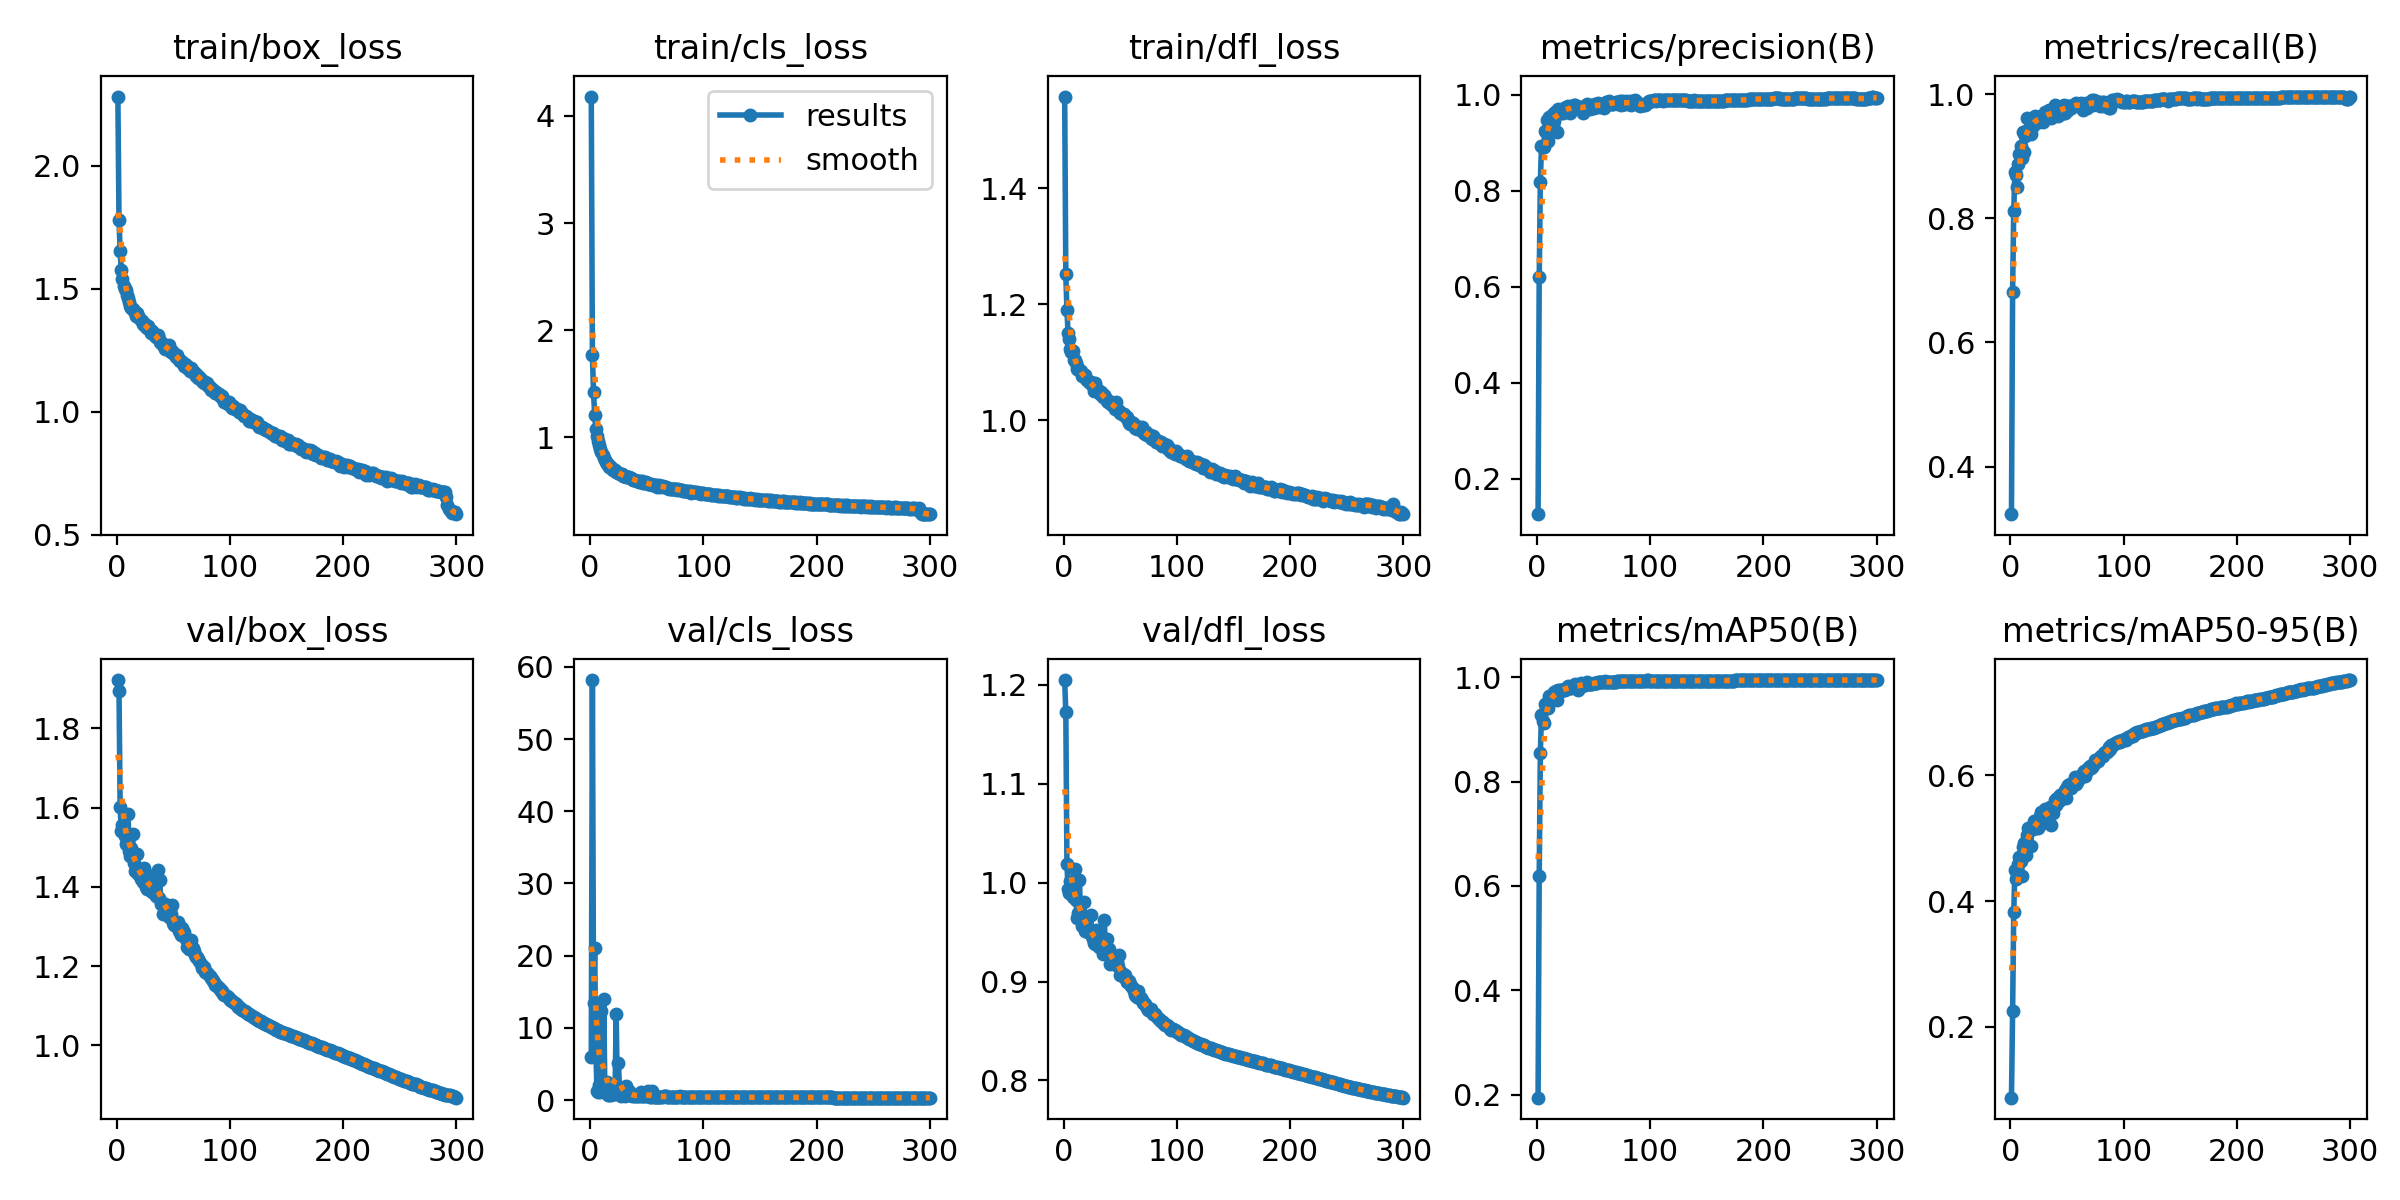

In [92]:
display(Image(experiment_path / "results.png"))

## 觀察驗證集的 Precision-Recall Curve 及 mAP@0.5

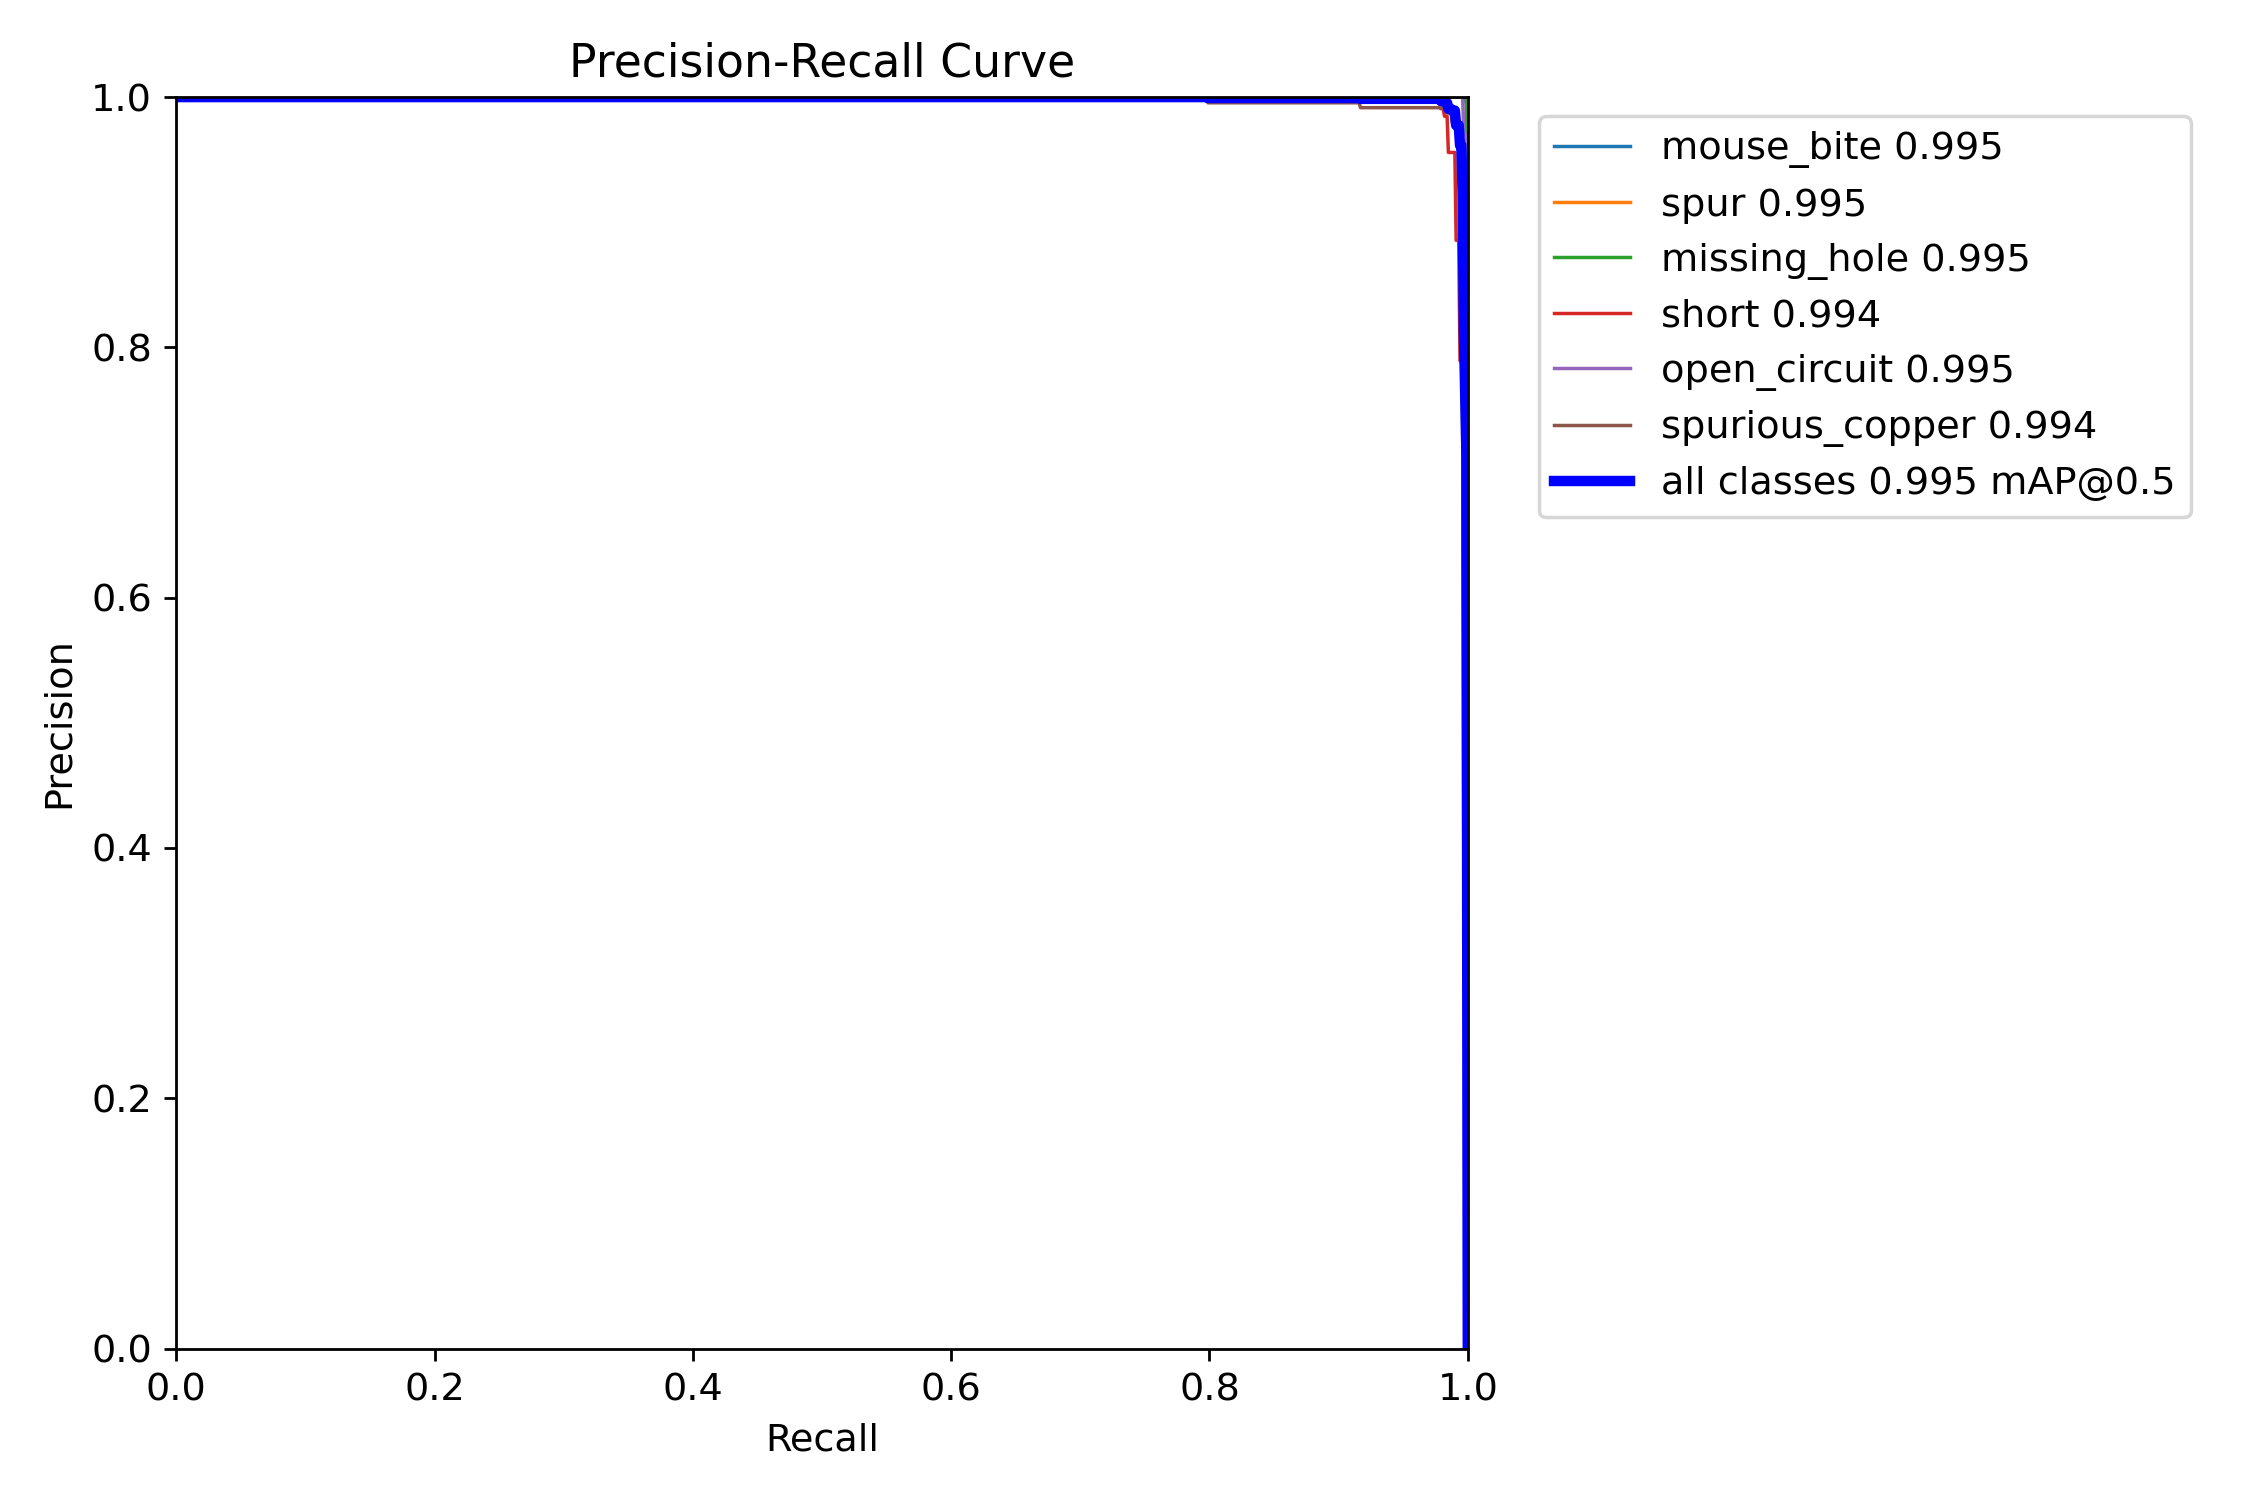

In [21]:
display(Image(experiment_path / "PR_curve.png"))

## 觀察驗證集的 F1-Confidence Curve

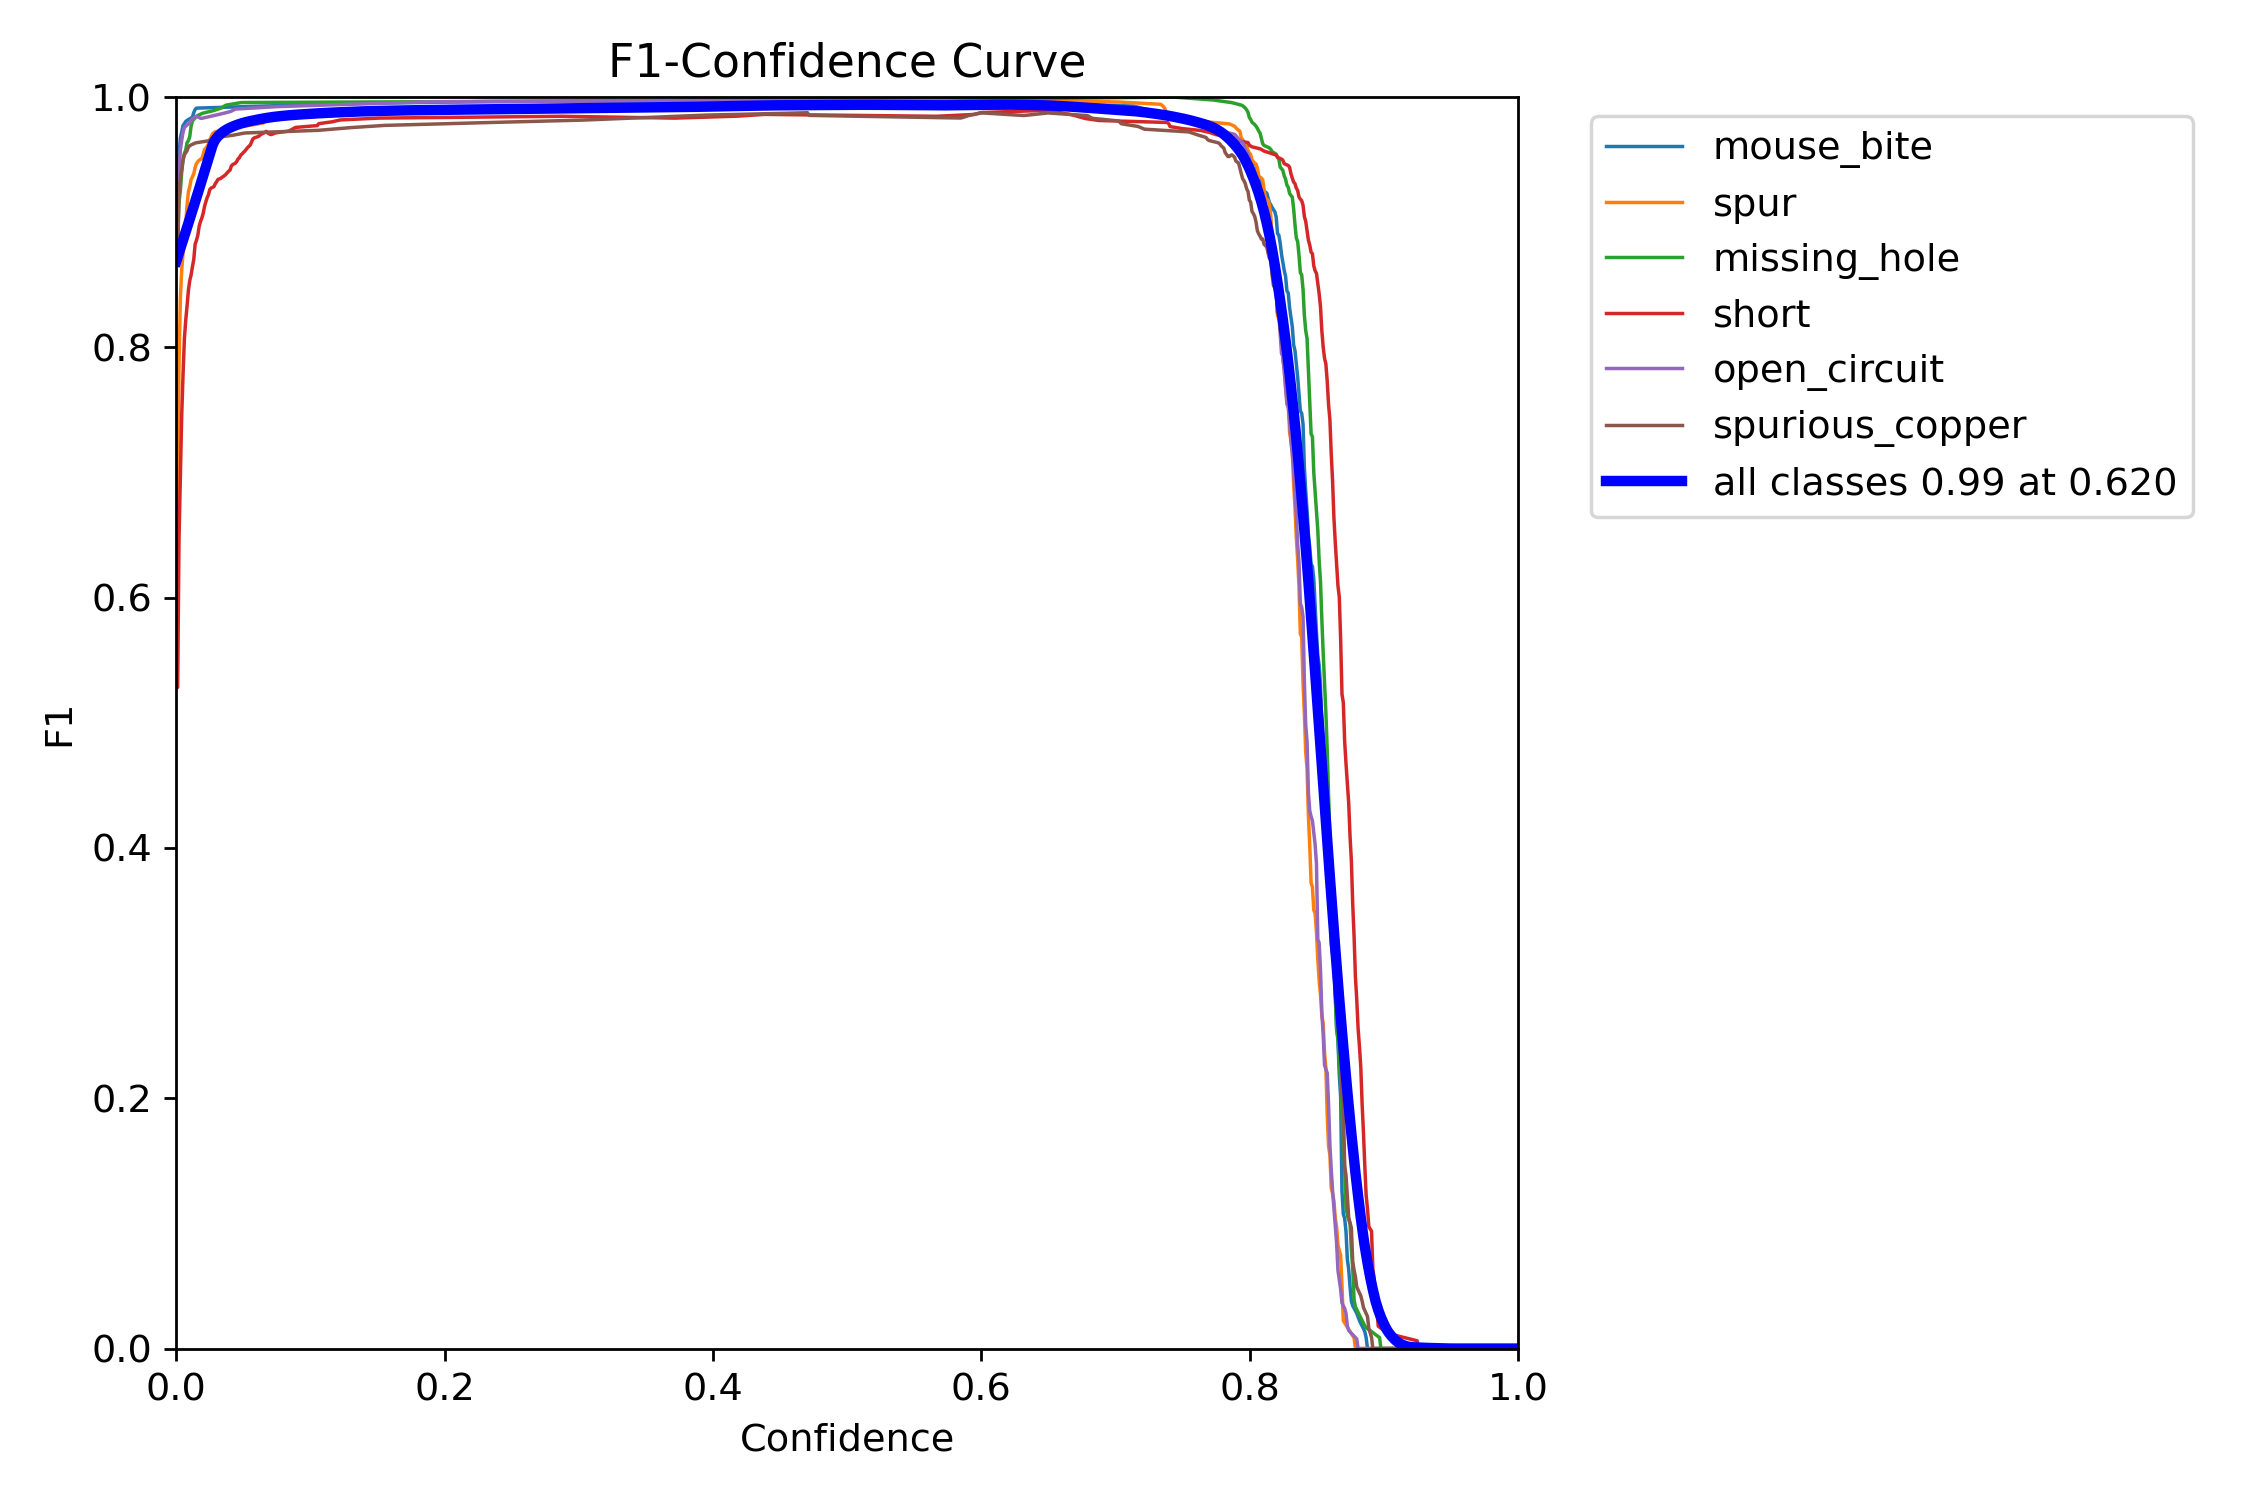

In [97]:
display(Image(experiment_path / "F1_curve.png"))

## 評估測試集

In [ ]:
test_setting = {
    "data": Path("dataset/pcb-defect-dataset/data.yaml").resolve(),
    "batch": 64,
    "imgsz": 600,
    "project": PROJECT,
    "name": NAME + "_test",
    "plots": True,
    "split": "test",
}

model = YOLO(experiment_path / "weights" / "best.pt")
results = model.val(**test_setting)

WARNING ⚠️ imgsz=[600] must be multiple of max stride 32, updating to [608]
Ultralytics 8.3.40 🚀 Python-3.11.10 torch-2.5.1+cu124 CUDA:0 (NVIDIA TITAN RTX, 24205MiB)
YOLO11s summary (fused): 238 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /home/g113056077/Projects/nchu-stuff/2024-fall/cv/pcb_defect_detection/dataset/pcb-defect-dataset/test/labels... 829 images, 239 backgrounds, 0 corrupt: 100%|██████████| 1068/1068 [00:00<00:00, 3462.57it/s]

val: New cache created: /home/g113056077/Projects/nchu-stuff/2024-fall/cv/pcb_defect_detection/dataset/pcb-defect-dataset/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


                   all       1068       1662      0.995      0.996      0.995      0.759
            mouse_bite        131        262      0.992          1      0.995      0.767
                  spur        138        279      0.991      0.996      0.995      0.759
          missing_hole        145        283      0.996          1      0.995      0.766
                 short        142        275          1      0.989      0.995      0.759
          open_circuit        128        265          1      0.996      0.995      0.738
       spurious_copper        145        298       0.99      0.996      0.993      0.764
Speed: 0.6ms preprocess, 2.9ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to pcb_defect/v3_test


# 觀察 Confusion Matrix

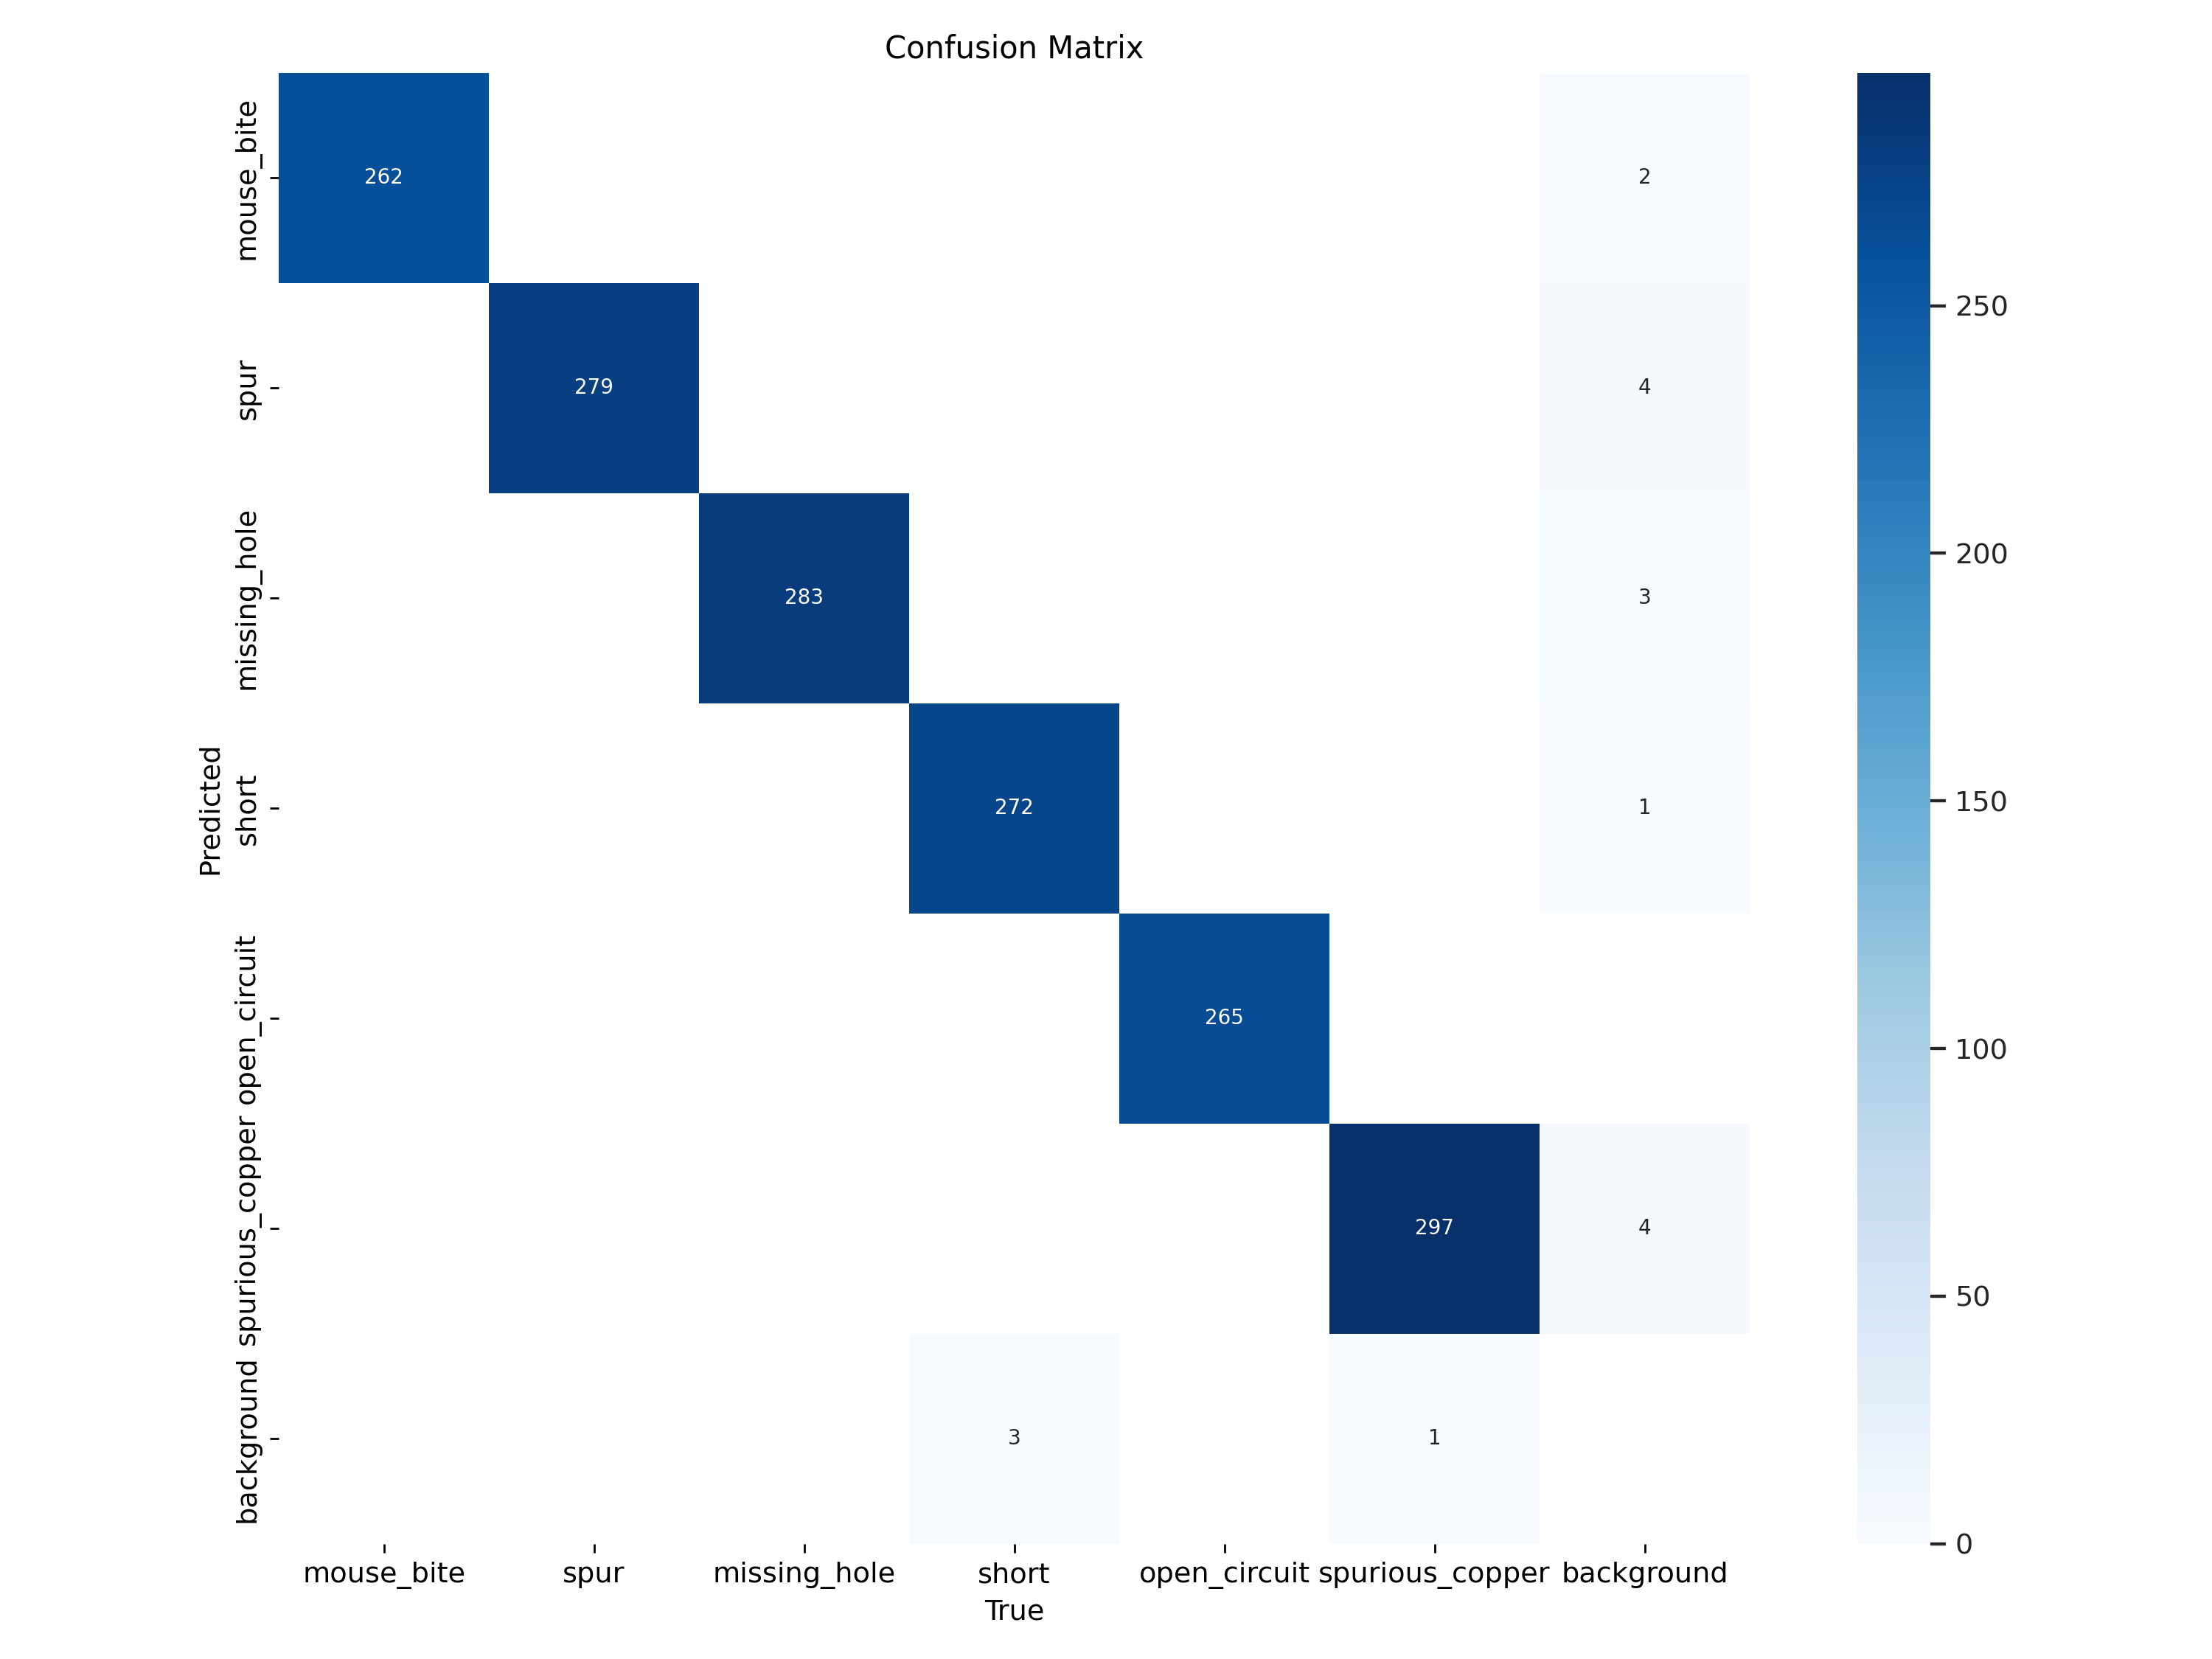

In [22]:
display(Image(experiment_test_path / "confusion_matrix.png"))

# 顯示真實標籤

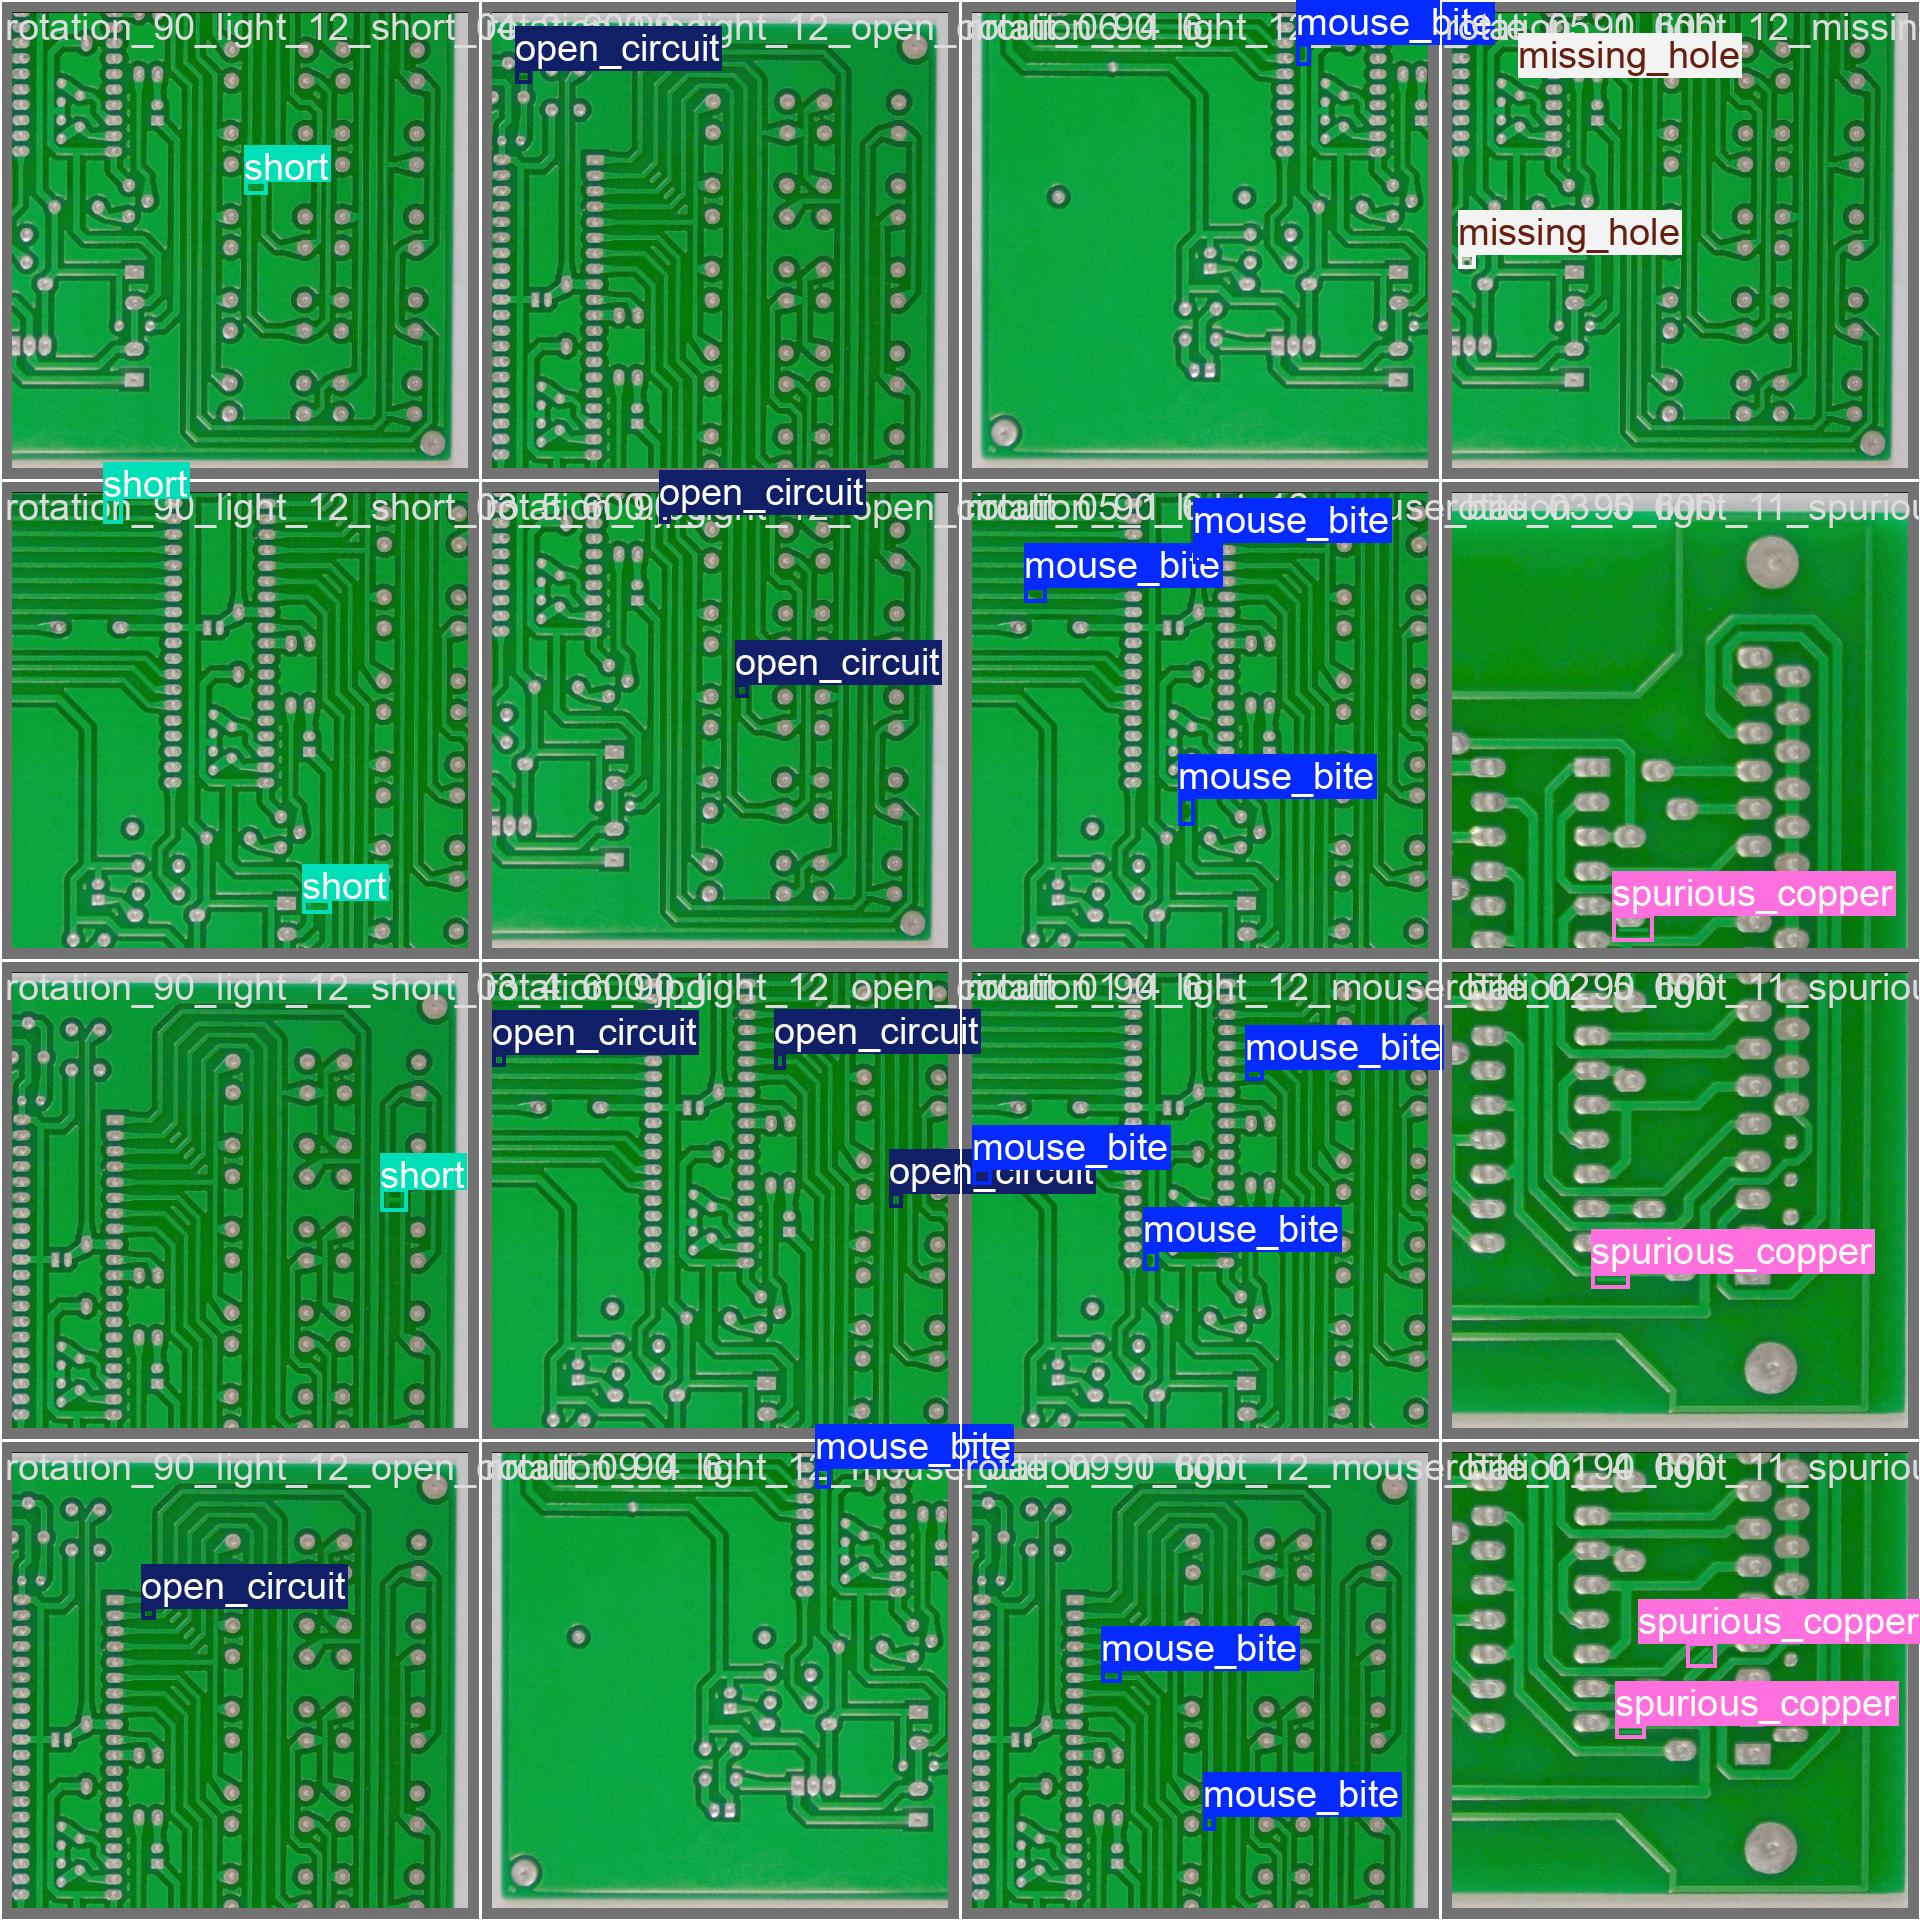

In [5]:
display(Image(experiment_test_path / "val_batch0_labels.jpg"))

## 觀察預測結果的圖片

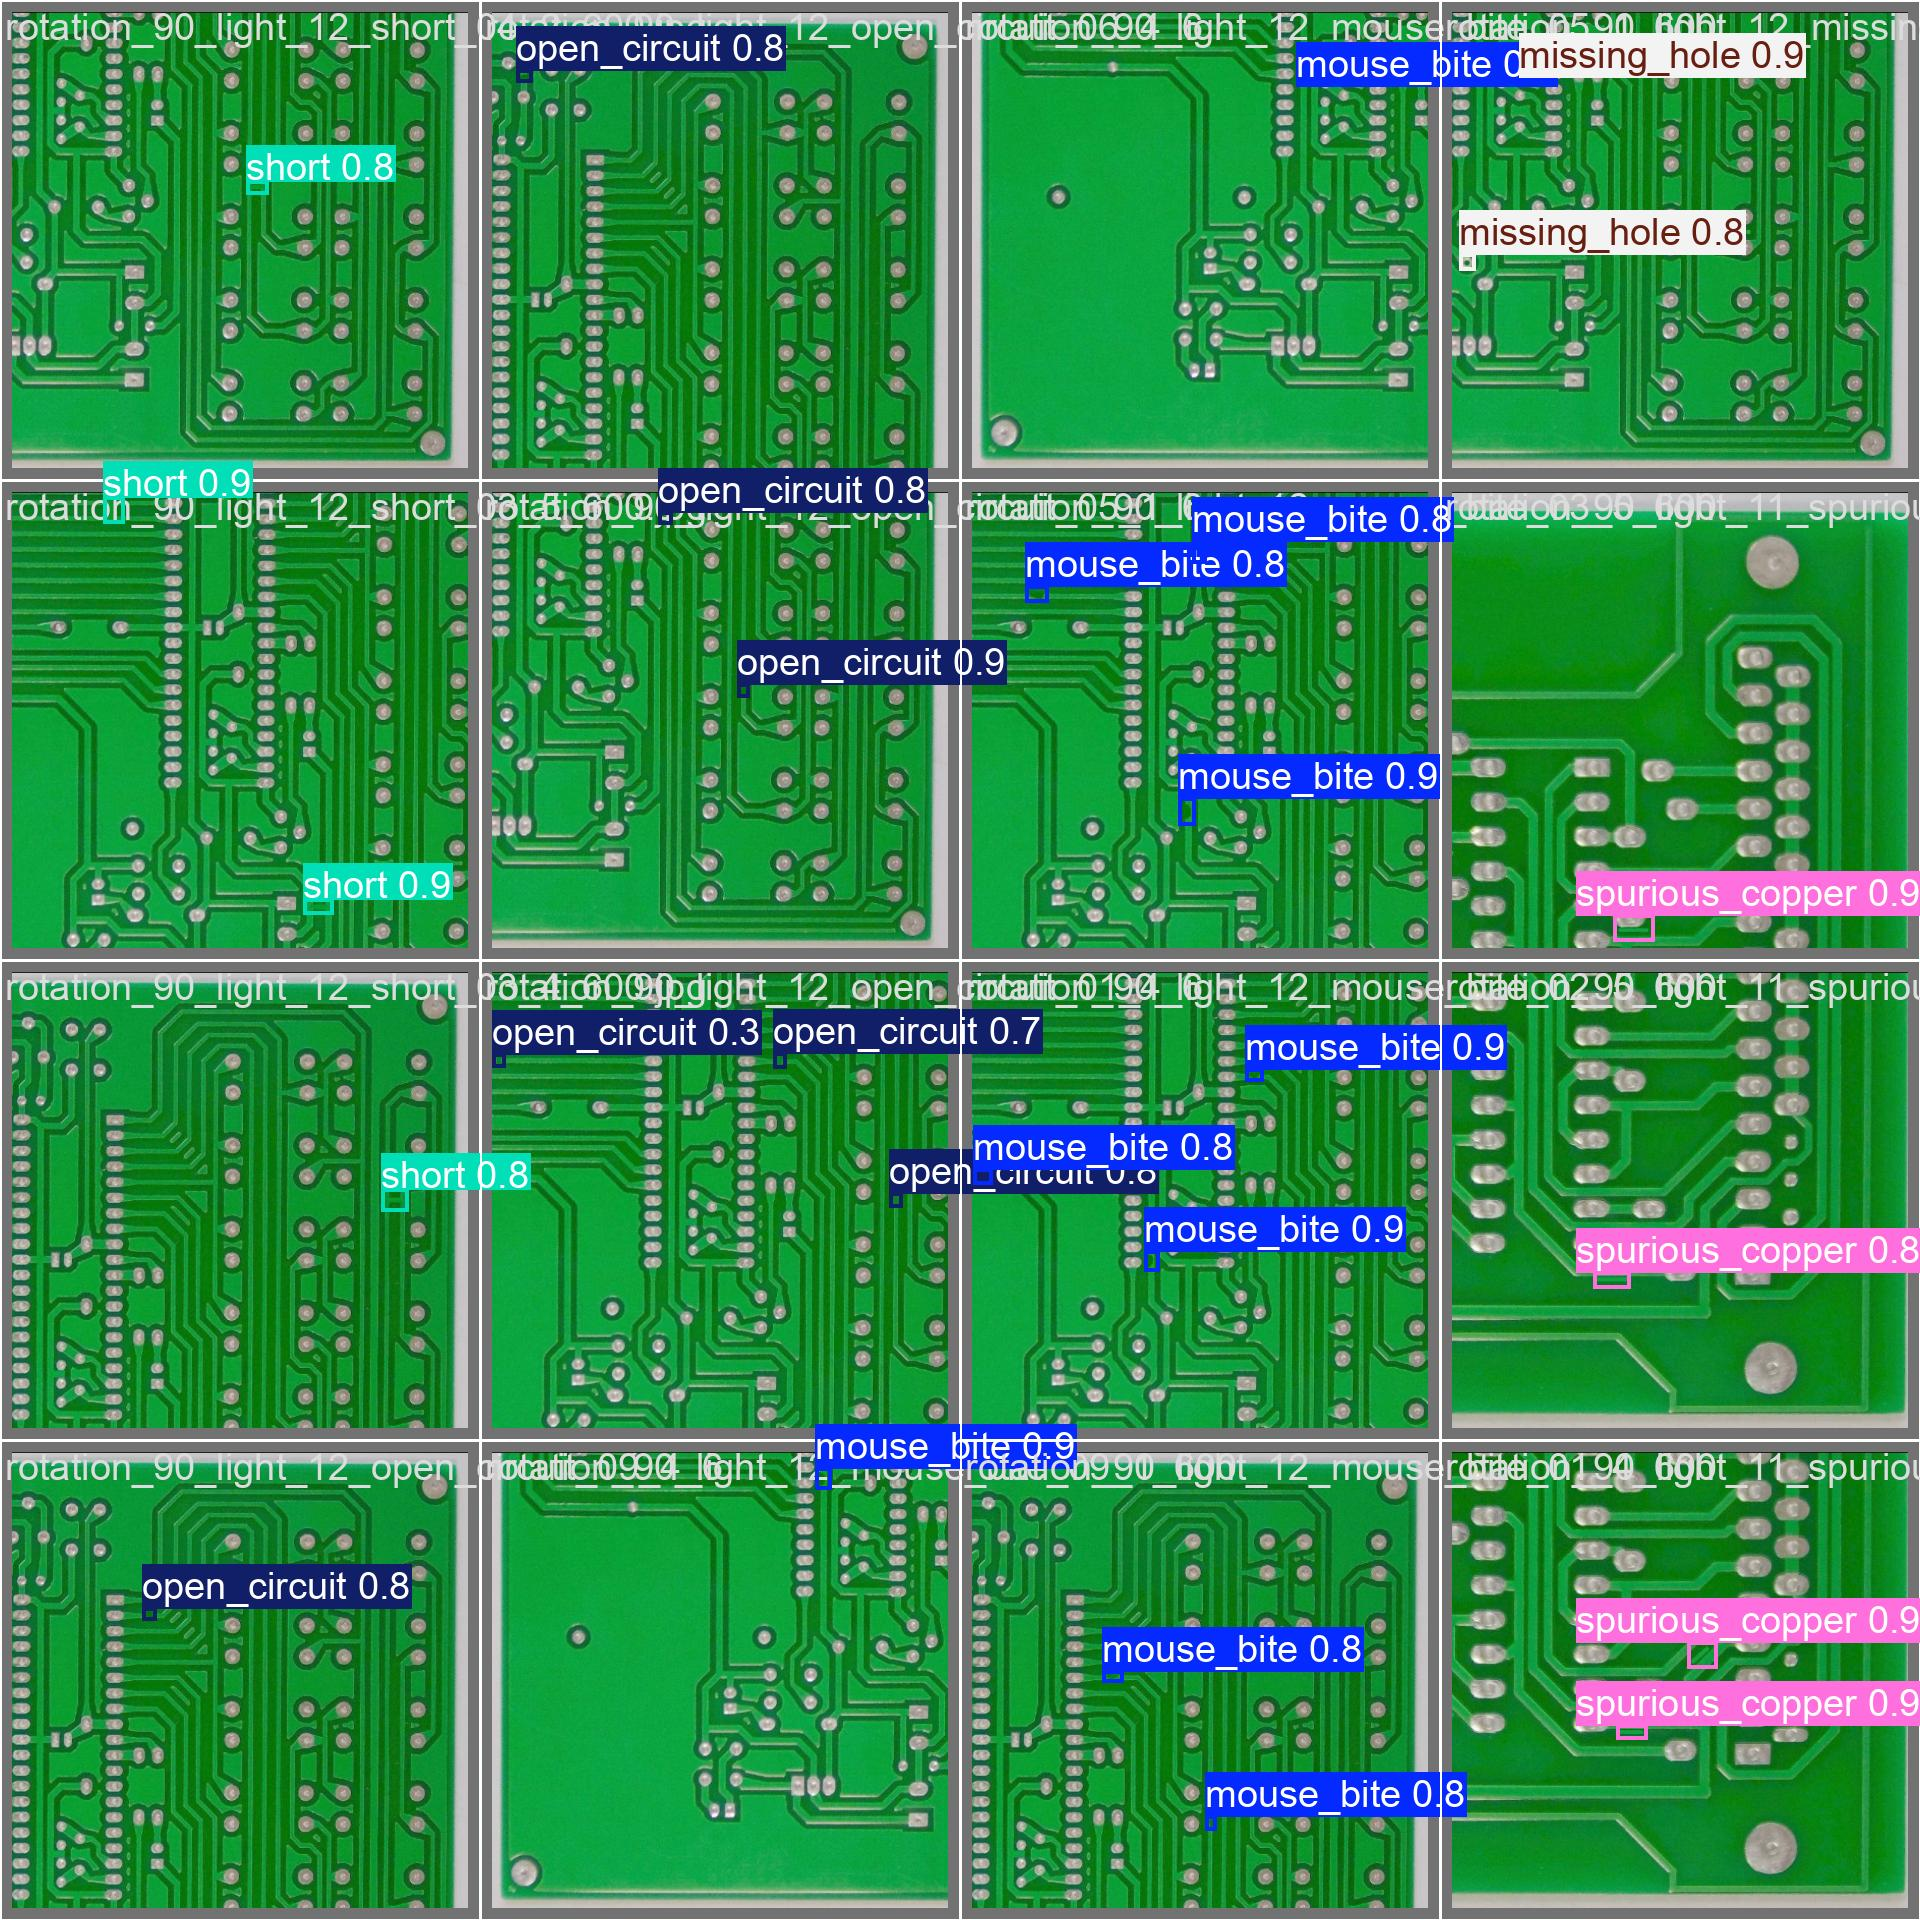

In [6]:
display(Image(experiment_test_path / "val_batch0_pred.jpg"))

## 觀察測試集的 Precision-Recall Curve 及 mAP@0.5

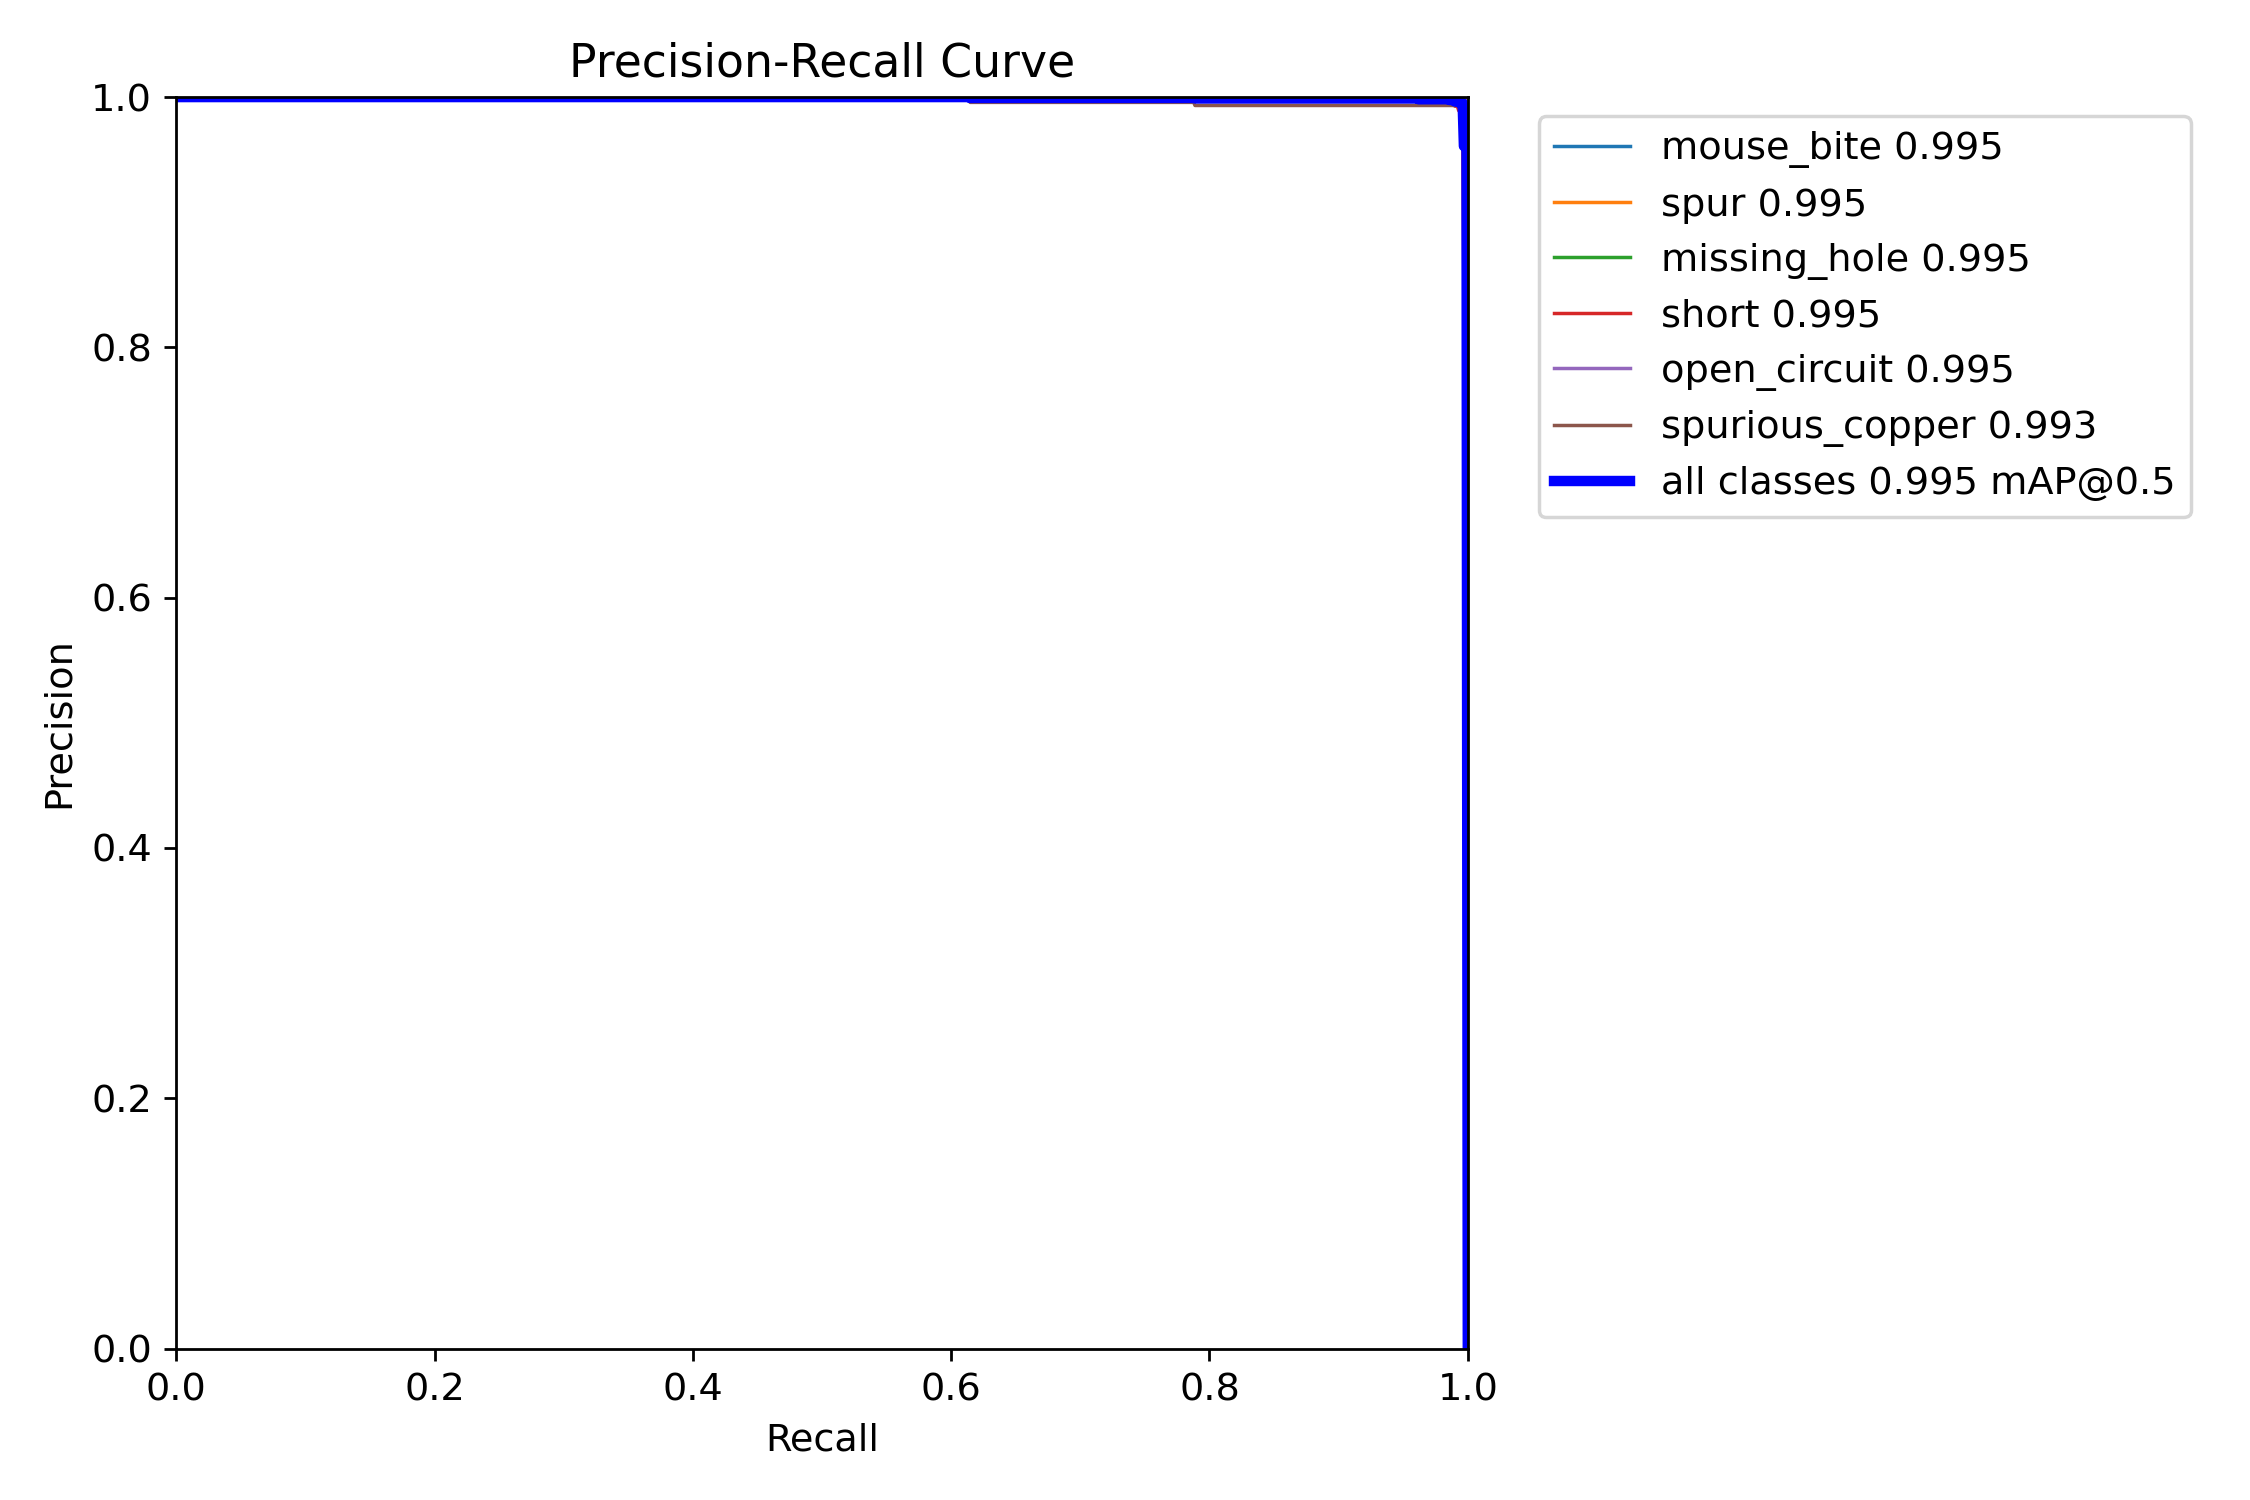

In [98]:
display(Image(experiment_test_path / "PR_curve.png"))

## 觀察測試集的 F1-Confidence Curve

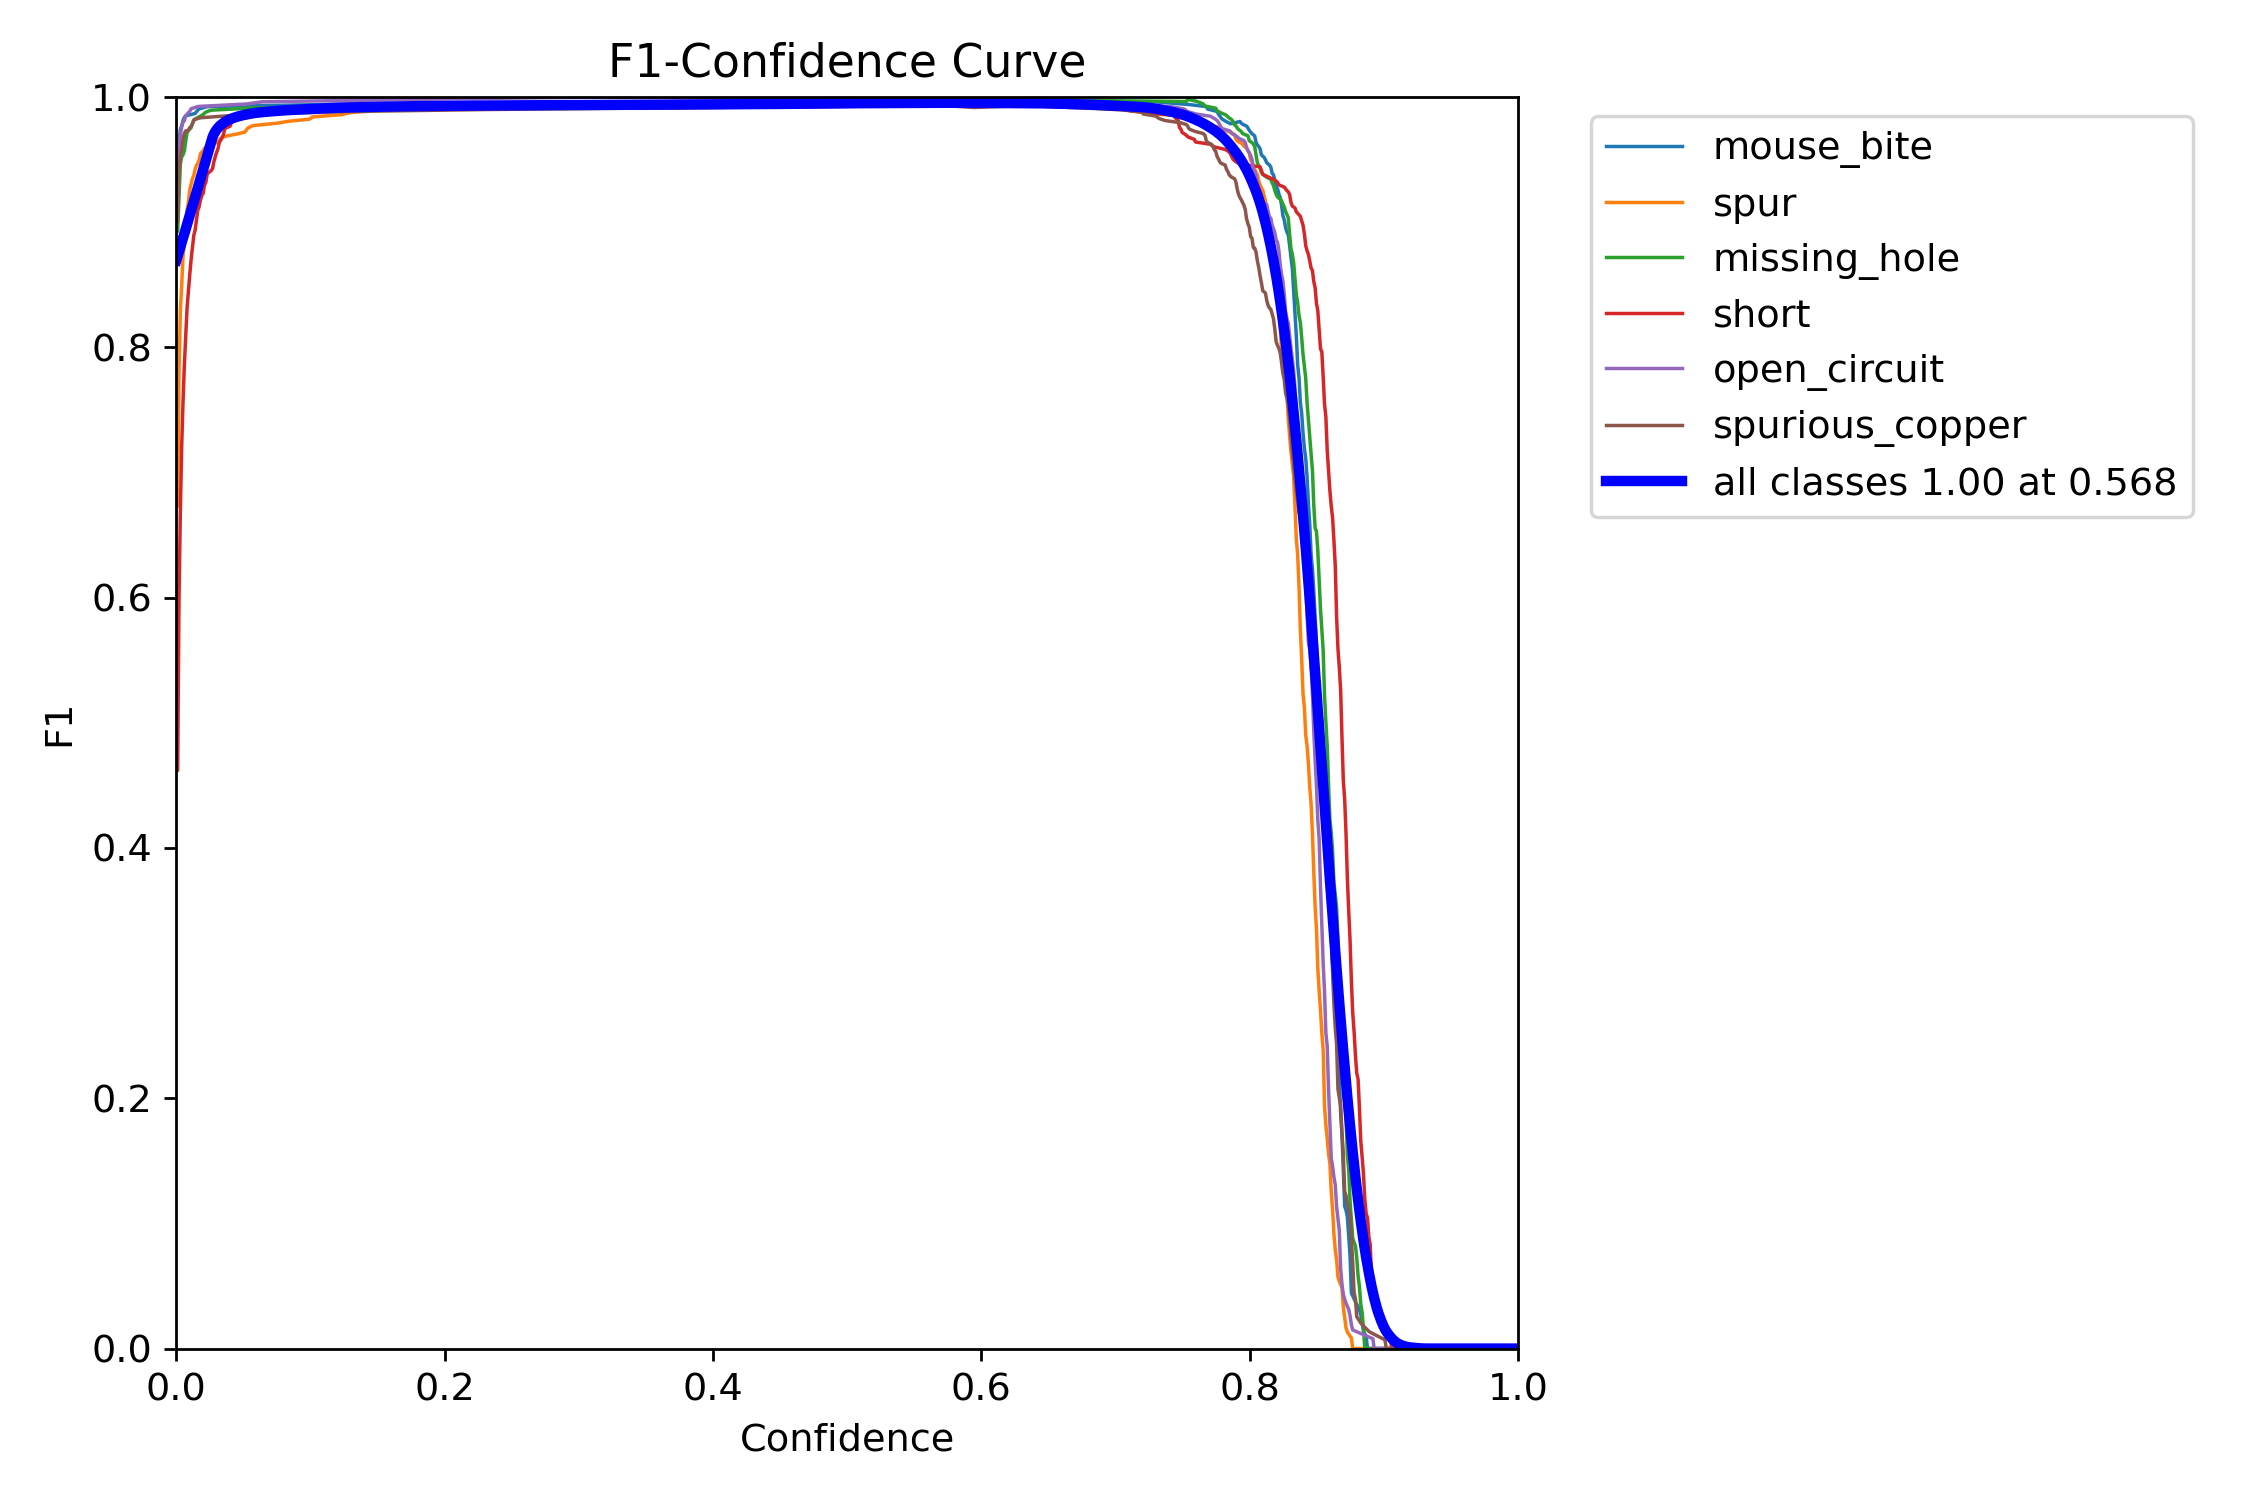

In [100]:
display(Image(experiment_test_path / "F1_curve.png"))